# Experimental Data Analysis

In [127]:
import pandas as pd
import numpy as np
from pathlib import Path
import re
import tempfile
import warnings

from typing import Optional
from rapidfuzz.distance import Levenshtein

from scipy import stats
from scipy.stats import shapiro, levene, fligner, wilcoxon, chi2, zscore, gaussian_kde
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

warnings.filterwarnings("ignore", category=FutureWarning, module="pingouin")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="numpy.linalg")
sns.set_theme(style="whitegrid")

## Configuration

In [128]:
# --- Preprocessing toggle ---
RECREATE_PREPROCESSED = False

# --- Paths ---
RAW_DATA_DIR = Path("../data/experiment/raw_data")
PREPROCESSED_DIR = Path(tempfile.mkdtemp(prefix="preprocessing_"))
# PREPROCESSED_DIR = Path("../data/experiment/data_preprocessed")  # Final path
DATA_DIR = Path("../data/experiment/data_preprocessed")

# --- Color palette ---
COLORS = {
    "primary_dark": "#000000",
    "teal": "#4A8A94",
    "pink": "#E5A3B8",
    "white": "#FFFFFF",
    "teal_dark": "#2E5A62",
    "pink_dark": "#D47A96",
}

CONDITION_COLORS = {
    "sequential": COLORS["teal"],
    "interrupted": COLORS["pink"],
}

plt.rcParams.update({
    "text.color": COLORS["primary_dark"],
    "axes.labelcolor": COLORS["primary_dark"],
    "xtick.color": COLORS["primary_dark"],
    "ytick.color": COLORS["primary_dark"],
    "axes.edgecolor": COLORS["primary_dark"],
    "figure.facecolor": COLORS["white"],
    "axes.facecolor": COLORS["white"],
})

# --- Analysis constants ---
ACC_THRESH = 0.85
IQR_K = 2.5
ALPHA = 0.05
WITHIN = ["COND_interruption_condition", "COND_nback_level"]
SUBJECT = "participant_id"
GROUP_COLS = ["participant_id", "COND_interruption_condition", "COND_nback_level"]
CONDITION_ORDER = ["Seq-Easy", "Seq-Hard", "Int-Easy", "Int-Hard"]

TRIAL_DVS = [
    "OUT_normalized_absolute_error",
    "OUT_time_estimation_ratio",
    "OUT_time_per_letter",
    "OUT_actual_trial_duration_sec",
]

## Preprocessing

In [129]:
def _latest_output_csv(participant_dir: Path, pid: str) -> Optional[Path]:
    """Return the Multitasking-Experiment file with the most recent timestamp."""
    pattern = f"{pid}_Multitasking_Experiment_UU_*.csv"
    candidates = sorted(participant_dir.glob(pattern))
    return candidates[-1] if candidates else None


def collect_demographics(raw_dir: Path) -> pd.DataFrame:
    """Return a DataFrame with participant_id, gender, age."""
    records = []
    for pdir in sorted(raw_dir.glob("part_*")):
        m = re.fullmatch(r"part_(\d{6})", pdir.name)
        if m is None:
            continue
        pid = m.group(1)
        out_csv = _latest_output_csv(pdir, pid)
        if out_csv is None:
            continue
        demo_row = pd.read_csv(
            out_csv,
            usecols=lambda c: c in {"cm_gender", "cm_age"},
            nrows=7,
        ).iloc[6]
        records.append({
            "participant_id": pid,
            "gender": demo_row.get("cm_gender", np.nan),
            "age": pd.to_numeric(demo_row.get("cm_age", np.nan), errors="coerce"),
        })
    return pd.DataFrame.from_records(records)


def preprocess_participant(participant_dir: Path, output_dir: Path) -> None:
    """Full cleaning pipeline for one participant directory."""
    match = re.fullmatch(r"part_(\d{6})", participant_dir.name)
    if match is None:
        return
    pid = match.group(1)
    output_csv = _latest_output_csv(participant_dir, pid)
    cond_csv = participant_dir / f"participant_{pid}.csv"
    if output_csv is None or not cond_csv.exists():
        print(f"Missing file(s) for participant {pid}; skipped.")
        return

    raw = pd.read_csv(output_csv)
    mask = raw["cm_experiment_phase"].isin(["practice", "main"]) & raw["cm_global_trial_number"].notna()
    df = raw.loc[mask].copy()
    df = df.loc[:, ~df.columns.duplicated()]

    keep = [
        "cm_experiment_phase", "cm_global_trial_number", "cm_block_number",
        "cm_target_word", "cm_target_word_length", "cm_interruption_condition",
        "cm_interrupt_positions", "cm_resumption_lag", "cm_entered_text",
        "cm_typing_correct", "cm_time_on_primary_task", "cm_nback_hits",
        "cm_nback_misses", "cm_nback_false_alarms", "cm_nback_correct_rejections",
        "cm_nback_accuracy", "cm_time_estimate_seconds",
        "cm_actual_trial_duration", "cm_actual_trial_duration_sec",
        "cm_time_estimation_ratio", "cm_gender", "cm_age",
    ]
    working_df = df[keep].copy()

    working_df["cm_global_trial_number"] = working_df["cm_global_trial_number"].astype("Int64")
    working_df["cm_block_number"] = working_df["cm_block_number"].astype("Int64")
    working_df["cm_target_word_length"] = working_df["cm_target_word_length"].astype("Int64")
    working_df["cm_time_estimate_seconds"] = working_df["cm_time_estimate_seconds"].astype("Int64")

    working_df = working_df.rename(columns={"cm_global_trial_number": "GLOBAL_TRIAL_NUM"})
    rename_map = {c: c.replace("cm_", "OUT_", 1) for c in working_df.columns if c.startswith("cm_")}
    working_df = working_df.rename(columns=rename_map).reset_index(drop=True)

    cond = pd.read_csv(cond_csv).copy()
    cond["GLOBAL_TRIAL_NUM"] = pd.Series(range(1, len(cond) + 1), dtype="Int64")
    cond = cond.rename(columns={"n_back": "nback_level"})
    cond = cond.rename(columns=lambda c: f"COND_{c}" if c != "GLOBAL_TRIAL_NUM" else c)

    merged = cond.merge(working_df, how="left", on="GLOBAL_TRIAL_NUM")
    ordered_cols = (
        ["GLOBAL_TRIAL_NUM"]
        + [c for c in merged.columns if c.startswith("COND_")]
        + [c for c in merged.columns if c.startswith("OUT_")]
    )
    merged = merged[ordered_cols]

    # Time perception metrics
    merged["OUT_time_estimation_ratio"] = (
        merged["OUT_time_estimate_seconds"] / merged["OUT_actual_trial_duration_sec"]
    )
    subjective = merged["OUT_time_estimate_seconds"]
    objective = merged["OUT_actual_trial_duration_sec"]
    merged["OUT_normalized_absolute_error"] = np.abs(subjective - objective) / objective
    merged["OUT_estimation_direction"] = np.select(
        [merged["OUT_time_estimation_ratio"] > 1, merged["OUT_time_estimation_ratio"] < 1],
        [1, -1], default=0,
    )

    # Performance features
    merged["OUT_time_per_letter"] = (
        merged["OUT_time_on_primary_task"] / merged["OUT_target_word_length"].replace({0: np.nan})
    )
    entered = merged["OUT_entered_text"].astype(str).fillna("")
    target = merged["OUT_target_word"].astype(str).fillna("")
    merged["OUT_typing_distance"] = [
        Levenshtein.distance(e, t) for e, t in zip(entered, target)
    ]

    out_file = output_dir / f"participant_{pid}_output_CLEAN.csv"
    merged.to_csv(out_file, index=False)
    print(f"Participant {pid}: processed -> {out_file}")


def preprocess_participants(raw_dir: Path, output_dir: Path) -> None:
    """Run preprocessing for all participant directories."""
    output_dir.mkdir(parents=True, exist_ok=True)
    for pdir in sorted(raw_dir.glob("part_*")):
        if pdir.is_dir():
            preprocess_participant(pdir, output_dir)

In [130]:
if RECREATE_PREPROCESSED:
    preprocess_participants(RAW_DATA_DIR, PREPROCESSED_DIR)
else:
    print("Preprocessing skipped (RECREATE_PREPROCESSED = False)")

Preprocessing skipped (RECREATE_PREPROCESSED = False)


In [131]:
demo_df = collect_demographics(RAW_DATA_DIR)
n = len(demo_df)
print(f"Participants: N = {n}")
print(f"\nGender counts")
print(demo_df["gender"].value_counts(dropna=False))
if demo_df["age"].notna().any():
    m = demo_df["age"].mean()
    sd = demo_df["age"].std()
    print(f"\nAge: M = {m:.1f}, SD = {sd:.1f} (range {int(demo_df['age'].min())}\u2013{int(demo_df['age'].max())})")

Participants: N = 26

Gender counts
gender
Male                         20
Female                        4
Non-binary / third gender     2
Name: count, dtype: int64

Age: M = 30.4, SD = 5.8 (range 21–41)


## Helper Functions

In [132]:
def coefficient_of_variation(x):
    """CV = SD / Mean."""
    mean_x = np.mean(x)
    return np.std(x, ddof=1) / mean_x if mean_x != 0 else np.nan


def flag_outliers_iqr(series, k=IQR_K):
    """Return boolean mask flagging values outside k * IQR."""
    q1, q3 = series.quantile(0.25), series.quantile(0.75)
    iqr = q3 - q1
    return (series < q1 - k * iqr) | (series > q3 + k * iqr)


def flag_outliers_iqr_grouped(df, dv, group_cols, k=IQR_K):
    """Flag outlier trials within each participant x condition cell using IQR."""
    mask = pd.Series(False, index=df.index)
    for _, grp in df.groupby(group_cols):
        if len(grp) < 4:
            continue
        flags = flag_outliers_iqr(grp[dv], k=k)
        mask.loc[grp.index] = flags
    return mask


def winsorise_to_median(series, flags):
    """Replace flagged values with the series median."""
    result = series.copy()
    result[flags] = series[~flags].median()
    return result


def mahalanobis_distances(df, cols):
    """Compute Mahalanobis distances for multivariate outlier detection."""
    X = df[cols].values
    mean = X.mean(axis=0)
    cov = np.cov(X.T)
    cov_inv = np.linalg.inv(cov)
    diff = X - mean
    md = np.sqrt(np.sum(diff @ cov_inv * diff, axis=1))
    p_values = 1 - chi2.cdf(md ** 2, df=len(cols))
    return md, p_values


def normality_check(agg_df, dv, within, subject):
    """Fit OLS model mirroring RM-ANOVA, test residual normality, show QQ-plot."""
    formula = f"{dv} ~ C({within[0]}) * C({within[1]})"
    model = sm.OLS.from_formula(formula, data=agg_df).fit()
    resid = model.resid
    w_stat, p_val = shapiro(resid)
    print(f"\nShapiro-Wilk on residuals of {dv}: W = {w_stat:.3f}, p = {p_val:.4f}")
    if p_val < ALPHA:
        print(f"  -> Residuals significantly deviate from normality (p < {ALPHA}).")
    else:
        print(f"  -> Residuals approximately normal (p >= {ALPHA}).")
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    pg.qqplot(resid, dist="norm", ax=ax)
    ax.set_title(f"QQ-Plot: {dv}", fontsize=11)
    plt.tight_layout()
    plt.show()
    return w_stat, p_val


def variance_equality_tests(agg_df, dv, group_col):
    """Run Brown-Forsythe and Fligner-Killeen tests."""
    groups = [g[dv].values for _, g in agg_df.groupby(group_col)]
    bf_stat, bf_p = levene(*groups, center="median")
    fk_stat, fk_p = fligner(*groups)
    print(f"\nVariance equality for {dv}:")
    print(f"  Brown-Forsythe: F = {bf_stat:.2f}, p = {bf_p:.3f}")
    print(f"  Fligner-Killeen: chi2 = {fk_stat:.2f}, p = {fk_p:.3f}")
    return (bf_stat, bf_p), (fk_stat, fk_p)


def report_rm_anova(df_long, dv):
    """Run and print a 2-factor repeated-measures ANOVA with post-hoc tests."""
    aov = pg.rm_anova(
        data=df_long, dv=dv, within=WITHIN, subject=SUBJECT, detailed=True
    )
    nice = (
        aov.rename(columns={"Source": "Effect", "ddof1": "df1", "ddof2": "df2", "p_unc": "p"})
        .loc[:, ["Effect", "SS", "df1", "df2", "MS", "F", "p", "ng2"]]
        .round({"SS": 4, "MS": 4, "F": 3, "p": 4, "ng2": 3})
    )
    nice["sig"] = np.where(nice["p"] < ALPHA, "*", "")
    print(f"\n=== Repeated-measures ANOVA on {dv} ===")
    print(nice.to_string(index=False))

    ph = pg.pairwise_tests(
        data=df_long, dv=dv, within=WITHIN, subject=SUBJECT,
        padjust="holm", parametric=True, effsize="hedges",
    )
    sig_ph = ph[ph["p_corr"] < ALPHA]
    print(f"\nPost-hoc paired t-tests (Holm-corrected, \u03b1 = .05)")
    if sig_ph.empty:
        print("  \u2013 none survive correction.")
    else:
        keep = (
            sig_ph[["A", "B", "T", "dof", "p_corr", "hedges"]]
            .rename(columns={"A": "Cell A", "B": "Cell B", "p_corr": "p_Holm", "hedges": "g"})
            .round({"T": 3, "p_Holm": 4, "g": 3})
        )
        print(keep.to_string(index=False))
    return aov


def art_anova(df, dv, within, subject):
    """Aligned Rank Transform ANOVA (Wobbrock et al., 2011)."""
    from scipy.stats import rankdata
    data = df.copy()
    results = []
    effects = within + [" x ".join(within)]

    for effect in effects:
        aligned = data[dv].copy()
        factors = effect.split(" x ") if " x " in effect else [effect]
        other_factors = [f for f in within if f not in factors]

        grand_mean = data[dv].mean()
        for of in other_factors:
            group_means = data.groupby(of)[dv].transform("mean")
            aligned = aligned - group_means + grand_mean
        if len(factors) < len(within):
            interaction_mean = data.groupby(within)[dv].transform("mean")
            cell_effect = interaction_mean - grand_mean
            for f in within:
                cell_effect = cell_effect - (data.groupby(f)[dv].transform("mean") - grand_mean)
            aligned = aligned - cell_effect

        data[f"aligned_{effect}"] = rankdata(aligned)
        aov = pg.rm_anova(
            data=data, dv=f"aligned_{effect}", within=within, subject=subject, detailed=True
        )
        if " x " in effect:
            interaction_source = f"{within[0]} * {within[1]}"
            row = aov[aov["Source"] == interaction_source].iloc[0]
        else:
            row = aov[aov["Source"] == effect].iloc[0]
        results.append({
            "Effect": effect,
            "F": row["F"],
            "df1": row["ddof1"],
            "df2": row["ddof2"],
            "p": row["p_unc"],
        })

    result_df = pd.DataFrame(results).round({"F": 2, "p": 4})
    result_df["sig"] = np.where(result_df["p"] < ALPHA, "*", "")
    print(f"\n=== ART ANOVA on {dv} ===")
    print(result_df.to_string(index=False))
    return result_df


def create_condition_label(row):
    """Map interruption x nback factors to a short label."""
    interruption = "Int" if "interrupted" in str(row["COND_interruption_condition"]) else "Seq"
    nback = "Easy" if row["COND_nback_level"] == 1 else "Hard"
    return f"{interruption}-{nback}"

## Data Loading

In [133]:
frames = []
for filepath in sorted(DATA_DIR.glob("participant_*_output_CLEAN.csv")):
    pid_match = re.search(r"participant_(\d+)_output_CLEAN\.csv", filepath.name)
    if not pid_match:
        continue
    df = pd.read_csv(filepath)
    df["participant_id"] = pid_match.group(1)
    frames.append(df)

df_all = pd.concat(frames, ignore_index=True)

numeric_cols = [
    "OUT_time_estimation_ratio", "OUT_normalized_absolute_error",
    "OUT_time_estimate_seconds", "OUT_nback_accuracy",
    "OUT_time_per_letter", "OUT_actual_trial_duration_sec",
    "OUT_typing_distance", "OUT_resumption_lag",
]
for col in numeric_cols:
    if col in df_all.columns:
        df_all[col] = pd.to_numeric(df_all[col], errors="coerce")

df_all["condition_label"] = df_all.apply(create_condition_label, axis=1)
df_all["condition_label"] = pd.Categorical(
    df_all["condition_label"], categories=CONDITION_ORDER, ordered=True,
)

print(f"Loaded {df_all['participant_id'].nunique()} participants, {len(df_all)} total trials.")

Loaded 26 participants, 1248 total trials.


## Data Cleaning

In [134]:
# Filter to main-phase trials
df_main = df_all.query("OUT_experiment_phase == 'main'").copy()
print(f"Main-phase trials: {len(df_main)}")

# Exclude trials with low N-back accuracy
df_main = df_main[df_main["OUT_nback_accuracy"] >= ACC_THRESH].copy()
print(f"After accuracy filter (>= {ACC_THRESH}): {len(df_main)} valid trials")

# Trial-level outlier detection using IQR (k=2.5)
# Applied to time perception and performance DVs, NOT typing_error
for dv in TRIAL_DVS:
    if dv in df_main.columns:
        df_main[f"outlier_{dv}"] = flag_outliers_iqr_grouped(
            df_main, dv, GROUP_COLS, k=IQR_K
        )

outlier_mask = df_main.filter(regex=r"^outlier_").any(axis=1)
n_removed = outlier_mask.sum()
df_clean = df_main[~outlier_mask].copy()

pct = 100 * n_removed / len(df_main)
print(f"\nOutlier removal: {n_removed} trials ({pct:.1f}%)")
print(f"Final dataset: {len(df_clean)} trials across {df_clean['participant_id'].nunique()} participants")

# Trials per participant
trials_per_p = df_clean.groupby("participant_id").size()
print(f"Trials per participant: M = {trials_per_p.mean():.1f}, "
      f"SD = {trials_per_p.std():.1f}, range {trials_per_p.min()}\u2013{trials_per_p.max()}")

Main-phase trials: 1040
After accuracy filter (>= 0.85): 997 valid trials

Outlier removal: 39 trials (3.9%)
Final dataset: 958 trials across 26 participants
Trials per participant: M = 36.8, SD = 2.1, range 31–40


## Descriptive Statistics

In [135]:
# General trial properties
print("=== General Trial Properties ===")
for col, label, fmt in [
    ("OUT_actual_trial_duration_sec", "Trial duration (s)", ".1f"),
    ("OUT_target_word_length", "Word length (chars)", ".1f"),
]:
    if col in df_clean.columns:
        m = df_clean[col].mean()
        sd = df_clean[col].std()
        print(f"  {label}: M = {m:{fmt}}, SD = {sd:{fmt}}")

# Task performance by interruption condition
print("\n=== Task Performance by Interruption Condition ===")
for cond in ["sequential", "interrupted"]:
    subset = df_clean[df_clean["COND_interruption_condition"] == cond]
    tpl_m = subset["OUT_time_per_letter"].mean()
    tpl_sd = subset["OUT_time_per_letter"].std()
    te_m = subset["OUT_typing_distance"].mean()
    te_sd = subset["OUT_typing_distance"].std()
    print(f"  {cond.capitalize()}: time_per_letter M = {tpl_m:.2f} (SD = {tpl_sd:.2f}), "
          f"typing_error M = {te_m:.2f} (SD = {te_sd:.2f})")

# Task performance by 2x2 condition
print("\n=== Task Performance by 2\u00d72 Condition ===")
perf_desc = (
    df_clean.groupby(["COND_interruption_condition", "COND_nback_level"])
    .agg(
        tpl_mean=("OUT_time_per_letter", "mean"),
        typing_err_mean=("OUT_typing_distance", "mean"),
    )
    .round(3)
)
display(perf_desc)

# Time perception by interruption condition
print("\n=== Time Perception by Interruption Condition ===")
for cond in ["sequential", "interrupted"]:
    subset = df_clean[df_clean["COND_interruption_condition"] == cond]
    ae_m = subset["OUT_normalized_absolute_error"].mean()
    ae_sd = subset["OUT_normalized_absolute_error"].std()
    so_m = subset["OUT_time_estimation_ratio"].mean()
    so_sd = subset["OUT_time_estimation_ratio"].std()
    print(f"  {cond.capitalize()}: absolute_error M = {ae_m:.3f} (SD = {ae_sd:.3f}), "
          f"SO_ratio M = {so_m:.3f} (SD = {so_sd:.3f})")

# Time perception by 2x2 condition
print("\n=== Time Perception by 2\u00d72 Condition ===")
# Aggregate at participant level first, then compute condition means
tp_part = df_clean.groupby(GROUP_COLS, as_index=False).agg(
    mean_abs_error=("OUT_normalized_absolute_error", "mean"),
    mean_SO_ratio=("OUT_time_estimation_ratio", "mean"),
    cv_estimate=("OUT_time_estimate_seconds", coefficient_of_variation),
)
tp_desc = (
    tp_part.groupby(["COND_interruption_condition", "COND_nback_level"])
    [["mean_abs_error", "mean_SO_ratio", "cv_estimate"]]
    .mean()
    .round(3)
)
display(tp_desc)

=== General Trial Properties ===
  Trial duration (s): M = 22.0, SD = 3.6
  Word length (chars): M = 7.5, SD = 1.1

=== Task Performance by Interruption Condition ===
  Sequential: time_per_letter M = 1.17 (SD = 0.25), typing_error M = 0.05 (SD = 0.35)
  Interrupted: time_per_letter M = 1.46 (SD = 0.37), typing_error M = 0.21 (SD = 0.68)

=== Task Performance by 2×2 Condition ===


tpl_mean  typing_err_mean
COND_interruption_condition COND_nback_level                           
interrupted                 1                    1.449            0.188
                            2                    1.477            0.233
sequential                  1                    1.174            0.052
                            2                    1.174            0.055


=== Time Perception by Interruption Condition ===
  Sequential: absolute_error M = 0.119 (SD = 0.105), SO_ratio M = 1.002 (SD = 0.159)
  Interrupted: absolute_error M = 0.133 (SD = 0.108), SO_ratio M = 0.997 (SD = 0.172)

=== Time Perception by 2×2 Condition ===


mean_abs_error  mean_SO_ratio  \
COND_interruption_condition COND_nback_level                                  
interrupted                 1                          0.141          0.985   
                            2                          0.131          1.004   
sequential                  1                          0.122          0.992   
                            2                          0.119          1.009   

                                              cv_estimate  
COND_interruption_condition COND_nback_level               
interrupted                 1                       0.127  
                            2                       0.111  
sequential                  1                       0.124  
                            2                       0.124

## Task Performance: 2\u00d72 Repeated-Measures ANOVAs

### Assumption Checking

In [136]:
# Aggregate to participant x condition level
agg_perf = df_clean.groupby(GROUP_COLS, as_index=False).agg(
    mean_time_per_letter=("OUT_time_per_letter", "mean"),
    mean_typing_error=("OUT_typing_distance", "mean"),
)

# Cell-level outlier screening
perf_dvs = ["mean_time_per_letter", "mean_typing_error"]

for dv in perf_dvs:
    # Univariate: z > 3.29 within each condition cell
    agg_perf["_outlier_uni"] = False
    for _, grp in agg_perf.groupby(["COND_interruption_condition", "COND_nback_level"]):
        z = zscore(grp[dv], nan_policy="omit")
        mask = np.abs(z) > 3.29
        agg_perf.loc[grp.index, "_outlier_uni"] = mask
    n_uni = agg_perf["_outlier_uni"].sum()
    if n_uni > 0:
        for idx in agg_perf.index[agg_perf["_outlier_uni"]]:
            row = agg_perf.loc[idx]
            cell_mask = (
                (agg_perf["COND_interruption_condition"] == row["COND_interruption_condition"])
                & (agg_perf["COND_nback_level"] == row["COND_nback_level"])
                & (agg_perf.index != idx)
            )
            agg_perf.loc[idx, dv] = agg_perf.loc[cell_mask, dv].median()
        print(f"{dv}: {n_uni} univariate outlier(s) winsorised (per-cell z > 3.29).")
    else:
        print(f"{dv}: no univariate outliers (all |z| < 3.29).")
    agg_perf.drop(columns=["_outlier_uni"], inplace=True)

# Multivariate: Mahalanobis distance on 4-cell vectors per participant per DV
for dv in perf_dvs:
    wide = (
        agg_perf.pivot(index="participant_id",
                       columns=["COND_interruption_condition", "COND_nback_level"],
                       values=dv)
        .dropna()
    )
    X = wide.values
    mean = X.mean(axis=0)
    cov = np.cov(X.T)
    if np.linalg.det(cov) == 0:
        print(f"{dv}: covariance matrix is singular; skipping multivariate check.")
        continue
    cov_inv = np.linalg.inv(cov)
    diff = X - mean
    md = np.sqrt(np.sum(diff @ cov_inv * diff, axis=1))
    cutoff = np.sqrt(chi2.ppf(1 - 0.001, df=wide.shape[1]))
    multi_flags = md > cutoff
    n_multi = multi_flags.sum()
    if n_multi > 0:
        outlier_pids = wide.index[multi_flags]
        for pid in outlier_pids:
            pid_mask = agg_perf["participant_id"] == pid
            cell_median = agg_perf.loc[~pid_mask, dv].median()
            agg_perf.loc[pid_mask, dv] = cell_median
        print(f"{dv}: {n_multi} multivariate outlier(s) winsorised.")
    else:
        print(f"{dv}: no multivariate outliers.")

agg_perf["condition_label"] = agg_perf.apply(create_condition_label, axis=1)

mean_time_per_letter: no univariate outliers (all |z| < 3.29).
mean_typing_error: 2 univariate outlier(s) winsorised (per-cell z > 3.29).
mean_time_per_letter: no multivariate outliers.
mean_typing_error: no multivariate outliers.



Shapiro-Wilk on residuals of mean_time_per_letter: W = 0.954, p = 0.0013
  -> Residuals significantly deviate from normality (p < 0.05).


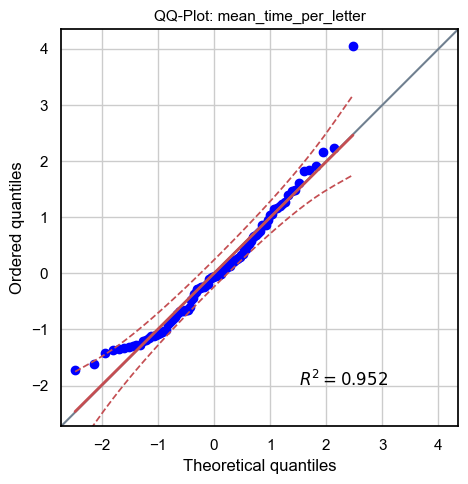


Shapiro-Wilk on residuals of mean_typing_error: W = 0.761, p = 0.0000
  -> Residuals significantly deviate from normality (p < 0.05).


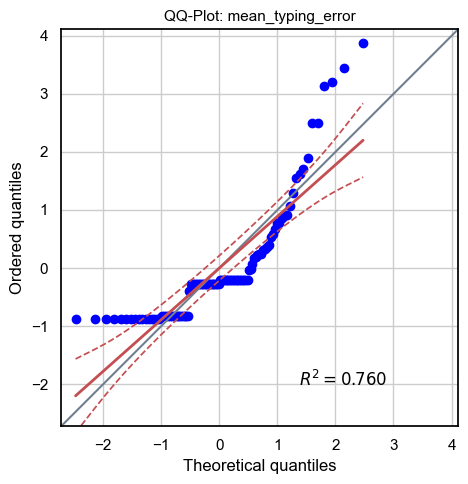

In [137]:
# Normality of residuals
for dv in perf_dvs:
    normality_check(agg_perf, dv, WITHIN, SUBJECT)

In [138]:
# Variance equality
for dv in perf_dvs:
    variance_equality_tests(agg_perf, dv, "condition_label" if "condition_label" in agg_perf.columns else WITHIN[0])


Variance equality for mean_time_per_letter:
  Brown-Forsythe: F = 0.98, p = 0.403
  Fligner-Killeen: chi2 = 2.33, p = 0.507

Variance equality for mean_typing_error:
  Brown-Forsythe: F = 3.14, p = 0.029
  Fligner-Killeen: chi2 = 6.95, p = 0.073


### Results

In [139]:
report_rm_anova(agg_perf, "mean_time_per_letter")


=== Repeated-measures ANOVA on mean_time_per_letter ===
                                        Effect     SS  df1  df2     MS       F      p   ng2 sig
                   COND_interruption_condition 2.1480    1   25 2.1480 105.552 0.0000 0.279   *
                              COND_nback_level 0.0068    1   25 0.0068   0.677 0.4185 0.001    
COND_interruption_condition * COND_nback_level 0.0075    1   25 0.0075   1.172 0.2894 0.001    

Post-hoc paired t-tests (Holm-corrected, α = .05)
  – none survive correction.


,Source,SS,ddof1,ddof2,MS,F,p_unc,p_GG_corr,ng2,eps
0,COND_interruption_condition,2.147995,1,25,2.147995,105.551576,1.853637e-10,1.853637e-10,0.278862,1.0
1,COND_nback_level,0.006838,1,25,0.006838,0.676765,4.184810e-01,4.184810e-01,0.001229,1.0
2,COND_interruption_condition * COND_nback_level,0.007508,1,25,0.007508,1.171562,2.894106e-01,2.894106e-01,0.001350,1.0


In [140]:
report_rm_anova(agg_perf, "mean_typing_error")


=== Repeated-measures ANOVA on mean_typing_error ===
                                        Effect     SS  df1  df2     MS     F      p   ng2 sig
                   COND_interruption_condition 0.4286    1   25 0.4286 7.797 0.0099 0.085   *
                              COND_nback_level 0.0051    1   25 0.0051 0.159 0.6937 0.001    
COND_interruption_condition * COND_nback_level 0.0003    1   25 0.0003 0.011 0.9157 0.000    

Post-hoc paired t-tests (Holm-corrected, α = .05)
  – none survive correction.


,Source,SS,ddof1,ddof2,MS,F,p_unc,p_GG_corr,ng2,eps
0,COND_interruption_condition,0.428614,1,25,0.428614,7.797448,0.009885,0.009885,0.085007,1.0
1,COND_nback_level,0.005070,1,25,0.005070,0.158727,0.693714,0.693714,0.001098,1.0
2,COND_interruption_condition * COND_nback_level,0.000328,1,25,0.000328,0.011446,0.915653,0.915653,0.000071,1.0


In [141]:
# ART ANOVA (robustness check)
for dv in perf_dvs:
    art_anova(agg_perf, dv, WITHIN, SUBJECT)


=== ART ANOVA on mean_time_per_letter ===
                                        Effect      F  df1  df2      p sig
                   COND_interruption_condition 192.69    1   25 0.0000   *
                              COND_nback_level   1.74    1   25 0.1995    
COND_interruption_condition x COND_nback_level   2.10    1   25 0.1596    

=== ART ANOVA on mean_typing_error ===
                                        Effect    F  df1  df2      p sig
                   COND_interruption_condition 4.21    1   25 0.0508    
                              COND_nback_level 0.31    1   25 0.5812    
COND_interruption_condition x COND_nback_level 0.21    1   25 0.6486    


### Visualizations

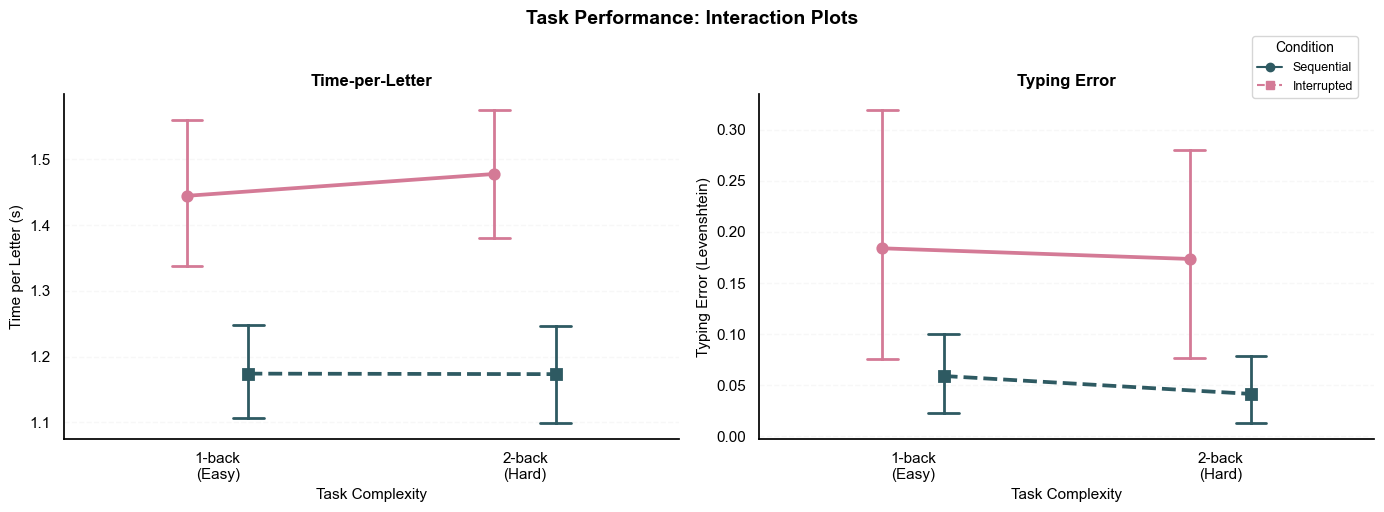

In [142]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, dv, ylabel, title in [
    (axes[0], "mean_time_per_letter", "Time per Letter (s)", "Time-per-Letter"),
    (axes[1], "mean_typing_error", "Typing Error (Levenshtein)", "Typing Error"),
]:
    sns.pointplot(
        data=agg_perf, x="COND_nback_level", y=dv,
        hue="COND_interruption_condition",
        dodge=0.2, markers=["o", "s"], linestyles=["-", "--"],
        palette={"sequential": COLORS["teal_dark"], "interrupted": COLORS["pink_dark"]},
        capsize=0.1, err_kws={"linewidth": 2}, ax=ax, legend=False,
    )
    ax.set_xlabel("Task Complexity", fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["1-back\n(Easy)", "2-back\n(Hard)"])
    ax.yaxis.grid(True, alpha=0.15, linestyle="--")
    ax.set_axisbelow(True)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

legend_elements = [
    Line2D([0], [0], color=COLORS["teal_dark"], linestyle="-", marker="o", markersize=6, label="Sequential"),
    Line2D([0], [0], color=COLORS["pink_dark"], linestyle="--", marker="s", markersize=6, label="Interrupted"),
]
fig.legend(handles=legend_elements, title="Condition", loc="upper right",
           bbox_to_anchor=(0.98, 0.98), frameon=True, fontsize=9, title_fontsize=10)
fig.suptitle("Task Performance: Interaction Plots", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

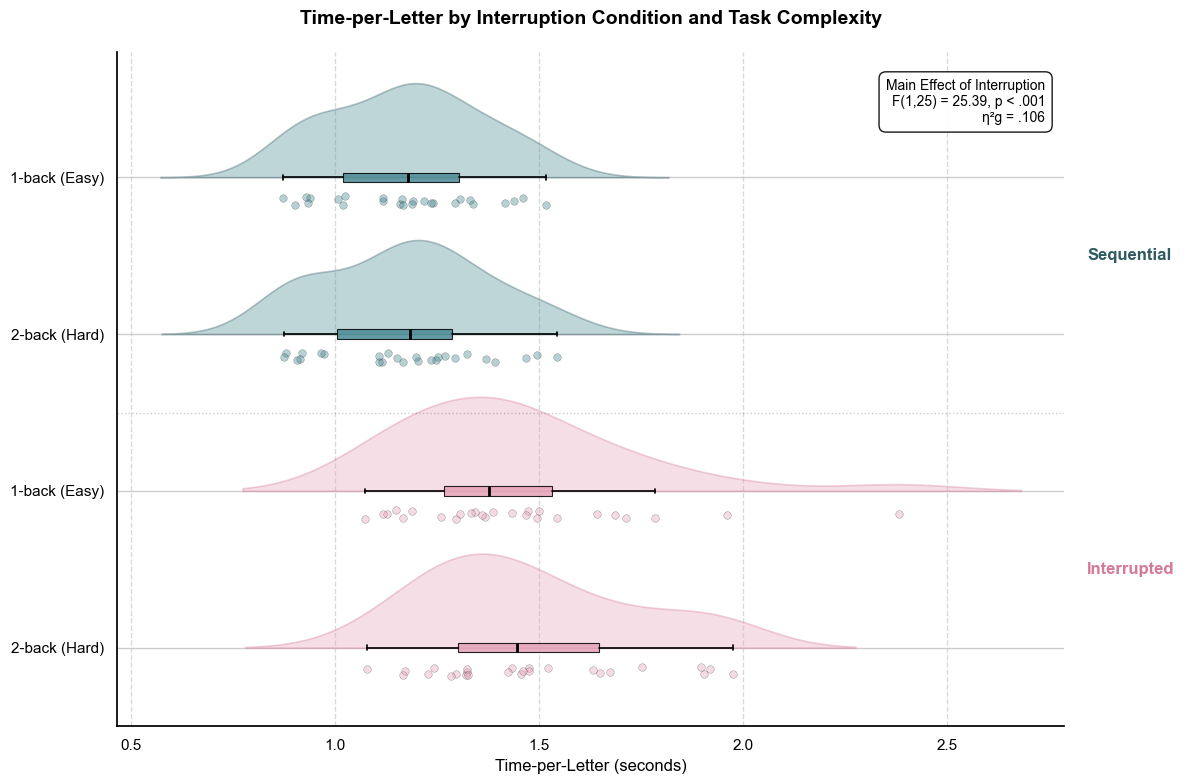

In [143]:
fig, ax = plt.subplots(figsize=(12, 8))

positions = {
    ('1', 'sequential'): 4,
    ('2', 'sequential'): 3,
    ('1', 'interrupted'): 2,
    ('2', 'interrupted'): 1
}

def plot_raincloud(data, y_pos, color, color_dark, ax):
    if len(data) == 0:
        return
    kde = gaussian_kde(data)
    x_range = np.linspace(data.min() - 0.3, data.max() + 0.3, 200)
    density = kde(x_range)
    density = density * 0.6 / density.max()

    ax.fill_between(x_range, y_pos, y_pos + density,
                    color=color, alpha=0.35, edgecolor=color_dark, linewidth=1.2)

    bp = ax.boxplot(data, positions=[y_pos], vert=False, widths=0.06,
                    patch_artist=True, showfliers=False,
                    boxprops=dict(facecolor=color, alpha=0.85, linewidth=0.8),
                    medianprops=dict(color=COLORS['primary_dark'], linewidth=2),
                    whiskerprops=dict(color=COLORS['primary_dark'], linewidth=1.2),
                    capprops=dict(color=COLORS['primary_dark'], linewidth=1.2))

    x_scatter = data
    y_scatter = np.full(len(x_scatter), y_pos - 0.12)
    y_scatter += np.random.uniform(-0.06, 0, len(x_scatter))
    ax.scatter(x_scatter, y_scatter, alpha=0.4, s=30, color=color,
               edgecolor=COLORS['primary_dark'], linewidth=0.3)

for (nback, condition), y_pos in positions.items():
    mask = (agg_perf['COND_nback_level'] == int(nback)) & (agg_perf['COND_interruption_condition'] == condition)
    data = agg_perf[mask]['mean_time_per_letter'].values
    color = COLORS['teal'] if condition == 'sequential' else COLORS['pink']
    color_dark = COLORS['teal_dark'] if condition == 'sequential' else COLORS['pink_dark']
    plot_raincloud(data, y_pos, color, color_dark, ax)

ax.axhline(y=2.5, color=COLORS['primary_dark'], linestyle=':', alpha=0.2, linewidth=1)
ax.set_yticks([4, 3, 2, 1])
ax.set_yticklabels(['1-back (Easy)', '2-back (Hard)', '1-back (Easy)', '2-back (Hard)'],
                   fontsize=11, color=COLORS['primary_dark'])

ax.text(ax.get_xlim()[1] * 1.02, 3.5, 'Sequential', fontsize=12,
        color=COLORS['teal_dark'], fontweight='bold', va='center')
ax.text(ax.get_xlim()[1] * 1.02, 1.5, 'Interrupted', fontsize=12,
        color=COLORS['pink_dark'], fontweight='bold', va='center')

ax.set_xlabel('Time-per-Letter (seconds)', fontsize=12, color=COLORS['primary_dark'])
ax.set_title('Time-per-Letter by Interruption Condition and Task Complexity',
             fontsize=14, fontweight='bold', color=COLORS['primary_dark'], pad=20)

ax.text(0.98, 0.96,
        'Main Effect of Interruption\nF(1,25) = 25.39, p < .001\nη²g = .106',
        transform=ax.transAxes,
        fontsize=10,
        ha='right',
        va='top',
        bbox=dict(boxstyle='round,pad=0.5',
                  facecolor='white',
                  edgecolor=COLORS['primary_dark'],
                  alpha=0.9))

ax.xaxis.grid(True, alpha=0.15, linestyle='--', color=COLORS['primary_dark'])
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(COLORS['primary_dark'])
ax.spines['bottom'].set_color(COLORS['primary_dark'])
ax.set_ylim(0.5, 4.8)
plt.tight_layout()
plt.show()

## Resumption Lag

RL_1back: 4 outlier(s) winsorised to median.

Shapiro-Wilk on difference scores: W(26) = 0.917, p = 0.038


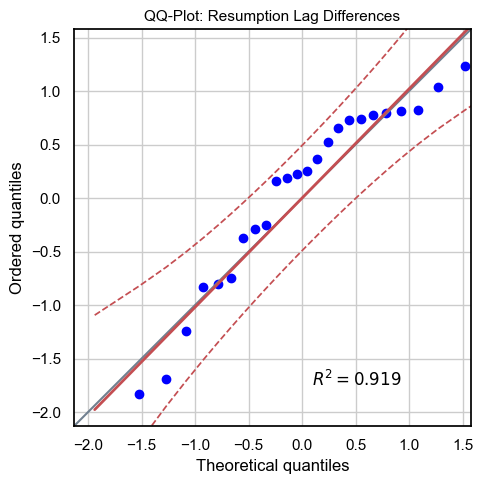


1-back: M = 1.81 s, SD = 0.39 s
2-back: M = 2.53 s, SD = 0.86 s
Mean difference: -0.72 s


In [144]:
# Filter to main-phase interrupted trials (from full dataset, before trial-level outlier removal)
df_int = df_all.query(
    "OUT_experiment_phase == 'main' and COND_interruption_condition == 'interrupted'"
).copy()

# Aggregate by participant x nback_level
rl_agg = (
    df_int.groupby(["participant_id", "COND_nback_level"])["OUT_resumption_lag"]
    .mean()
    .reset_index()
)

# Pivot to wide format
rl_wide = rl_agg.pivot(index="participant_id", columns="COND_nback_level", values="OUT_resumption_lag")
rl_wide.columns = ["RL_1back", "RL_2back"]
rl_wide = rl_wide.dropna().reset_index()

# IQR outlier screening (k=1.5) and winsorisation
for col in ["RL_1back", "RL_2back"]:
    flags = flag_outliers_iqr(rl_wide[col], k=1.5)
    n_out = flags.sum()
    if n_out > 0:
        rl_wide[col] = winsorise_to_median(rl_wide[col], flags)
        print(f"{col}: {n_out} outlier(s) winsorised to median.")

# Difference scores
rl_wide["diff"] = rl_wide["RL_1back"] - rl_wide["RL_2back"]

# Normality of difference scores
w_stat, p_val = shapiro(rl_wide["diff"])
print(f"\nShapiro-Wilk on difference scores: W({len(rl_wide)}) = {w_stat:.3f}, p = {p_val:.3f}")

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
pg.qqplot(rl_wide["diff"], dist="norm", ax=ax)
ax.set_title("QQ-Plot: Resumption Lag Differences", fontsize=11)
plt.tight_layout()
plt.show()

print(f"\n1-back: M = {rl_wide['RL_1back'].mean():.2f} s, SD = {rl_wide['RL_1back'].std():.2f} s")
print(f"2-back: M = {rl_wide['RL_2back'].mean():.2f} s, SD = {rl_wide['RL_2back'].std():.2f} s")
print(f"Mean difference: {rl_wide['diff'].mean():.2f} s")

### Statistical Tests

In [145]:
x = rl_wide["RL_1back"].values
y = rl_wide["RL_2back"].values

# Wilcoxon signed-rank test (one-tailed: 1-back < 2-back)
wx_stat, wx_p = wilcoxon(x, y, alternative="less")
print(f"Wilcoxon signed-rank test (one-tailed): W = {wx_stat}, p = {wx_p:.4g}")

# Paired t-test (confirmatory)
t_result = pg.ttest(x, y, paired=True, alternative="less")
t_val = t_result["T"].values[0]
t_dof = t_result["dof"].values[0]
t_p = t_result["p_val"].values[0]
cohen_d = t_result["cohen_d"].values[0]
print(f"\nPaired t-test (one-tailed): t({t_dof}) = {t_val:.2f}, p = {t_p:.4g}")
print(f"Cohen's d = {cohen_d:.2f}")

Wilcoxon signed-rank test (one-tailed): W = 19.0, p = 4.575e-06

Paired t-test (one-tailed): t(25) = -4.78, p = 3.26e-05
Cohen's d = 1.08


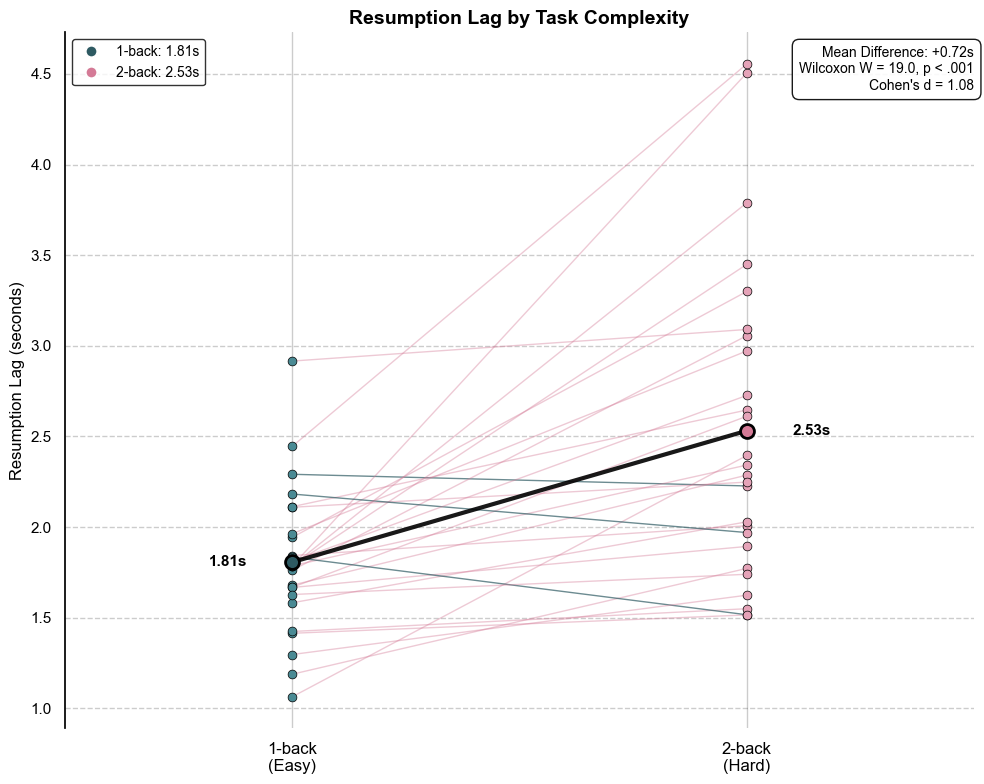

In [146]:
fig, ax = plt.subplots(figsize=(10, 8))

x_positions = [1, 2]

for idx, row in rl_wide.iterrows():
    rl_1back = row['RL_1back']
    rl_2back = row['RL_2back']

    if rl_2back > rl_1back:
        line_color = COLORS['pink_dark']
        alpha = 0.4
    else:
        line_color = COLORS['teal_dark']
        alpha = 0.7

    ax.plot(x_positions, [rl_1back, rl_2back],
            color=line_color, linewidth=1, alpha=alpha, zorder=1)

    ax.scatter(1, rl_1back, color=COLORS['teal'], s=40,
               edgecolor=COLORS['primary_dark'], linewidth=0.5, zorder=2)
    ax.scatter(2, rl_2back, color=COLORS['pink'], s=40,
               edgecolor=COLORS['primary_dark'], linewidth=0.5, zorder=2)

mean_1back = rl_wide['RL_1back'].mean()
mean_2back = rl_wide['RL_2back'].mean()

ax.plot(x_positions, [mean_1back, mean_2back],
        color=COLORS['primary_dark'], linewidth=3, alpha=0.9, zorder=3)

ax.scatter(1, mean_1back, color=COLORS['teal_dark'], s=100,
           edgecolor=COLORS['primary_dark'], linewidth=2, zorder=4, marker='o')
ax.scatter(2, mean_2back, color=COLORS['pink_dark'], s=100,
           edgecolor=COLORS['primary_dark'], linewidth=2, zorder=4, marker='o')

ax.text(0.9, mean_1back, f'{mean_1back:.2f}s',
        ha='right', va='center', fontsize=11, fontweight='bold',
        color=COLORS['primary_dark'])
ax.text(2.1, mean_2back, f'{mean_2back:.2f}s',
        ha='left', va='center', fontsize=11, fontweight='bold',
        color=COLORS['primary_dark'])

ax.set_xticks(x_positions)
ax.set_xticklabels(['1-back\n(Easy)', '2-back\n(Hard)'],
                   fontsize=12, color=COLORS['primary_dark'])
ax.set_ylabel('Resumption Lag (seconds)', fontsize=12, color=COLORS['primary_dark'])
ax.set_title('Resumption Lag by Task Complexity',
             fontsize=14, fontweight='bold', color=COLORS['primary_dark'])

ax.yaxis.grid(True, alpha=0.2, linestyle='--', color=COLORS['primary_dark'])
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(COLORS['primary_dark'])
ax.spines['bottom'].set_visible(False)
ax.set_xlim(0.5, 2.5)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=COLORS['teal_dark'],
           markersize=8, label=f'1-back: {mean_1back:.2f}s'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=COLORS['pink_dark'],
           markersize=8, label=f'2-back: {mean_2back:.2f}s')
]
ax.legend(handles=legend_elements, loc='upper left', frameon=True,
          fontsize=10, edgecolor=COLORS['primary_dark'])

effect = mean_2back - mean_1back
ax.text(1, 0.98,
        f'Mean Difference: +{effect:.2f}s\nWilcoxon W = 19.0, p < .001\nCohen\'s d = 1.08',
        transform=ax.transAxes,
        ha='right', va='top', fontsize=10,
        bbox=dict(boxstyle='round,pad=0.5', facecolor=COLORS['white'],
                  edgecolor=COLORS['primary_dark'], alpha=0.9))

plt.tight_layout()
plt.show()

## Effects of Interruption Duration

In [147]:
# Prepare data: interrupted trials with nback duration
df_dur = df_int.copy()

# Compute nback duration column if not present
if "OUT_nback_duration" not in df_dur.columns:
    nback_dur_candidates = [c for c in df_dur.columns if "nback" in c.lower() and "duration" in c.lower()]
    if nback_dur_candidates:
        nback_dur_col = nback_dur_candidates[0]
    else:
        # Approximate from trial duration - time on primary task
        df_dur["nback_duration"] = (
            df_dur["OUT_actual_trial_duration_sec"]
            - df_dur["OUT_time_on_primary_task"] / 1000.0
        )
        nback_dur_col = "nback_duration"
else:
    nback_dur_col = "OUT_nback_duration"

df_dur["nback_duration_s"] = pd.to_numeric(df_dur[nback_dur_col], errors="coerce")
# If duration is in ms, convert to seconds
if df_dur["nback_duration_s"].median() > 100:
    df_dur["nback_duration_s"] = df_dur["nback_duration_s"] / 1000.0

# Bivariate correlations
print("=== Bivariate Correlations (interrupted trials) ===")
for dv, label in [("OUT_resumption_lag", "resumption_lag"), ("OUT_typing_distance", "typing_error")]:
    subset = df_dur[["nback_duration_s", dv]].dropna()
    r, p = stats.pearsonr(subset["nback_duration_s"], subset[dv])
    print(f"  Duration vs {label}: r({len(subset)-2}) = {r:.3f}, p = {p:.3f}")

# LMM 1: resumption_lag
print("\n=== LMM: Resumption Lag ===")
df_lmm = df_dur[["participant_id", "COND_nback_level", "nback_duration_s", "OUT_resumption_lag"]].dropna()
df_lmm["nback_level"] = df_lmm["COND_nback_level"].astype(str)
md1 = smf.mixedlm("OUT_resumption_lag ~ C(nback_level) * nback_duration_s",
                   data=df_lmm, groups=df_lmm["participant_id"]).fit()
print(md1.summary().tables[1])

# LMM 2: typing_error
print("\n=== LMM: Typing Error ===")
df_lmm2 = df_dur[["participant_id", "COND_nback_level", "nback_duration_s", "OUT_typing_distance"]].dropna()
df_lmm2["nback_level"] = df_lmm2["COND_nback_level"].astype(str)
md2 = smf.mixedlm("OUT_typing_distance ~ C(nback_level) * nback_duration_s",
                   data=df_lmm2, groups=df_lmm2["participant_id"]).fit()
print(md2.summary().tables[1])

=== Bivariate Correlations (interrupted trials) ===
  Duration vs resumption_lag: r(518) = 0.061, p = 0.167
  Duration vs typing_error: r(518) = 0.027, p = 0.533

=== LMM: Resumption Lag ===
                                       Coef. Std.Err.       z  P>|z|  [0.025  \
Intercept                              1.243    0.485   2.563  0.010   0.292   
C(nback_level)[T.2]                    0.606    0.652   0.929  0.353  -0.673   
nback_duration_s                       0.092    0.043   2.131  0.033   0.007   
C(nback_level)[T.2]:nback_duration_s  -0.028    0.061  -0.458  0.647  -0.147   
Group Var                              0.632    0.142                          

                                     0.975]  
Intercept                             2.193  
C(nback_level)[T.2]                   1.884  
nback_duration_s                      0.177  
C(nback_level)[T.2]:nback_duration_s  0.092  
Group Var                                    

=== LMM: Typing Error ===
                         

,r,dof,pval,CI95,power
rm_corr,0.128539,493,0.004177,"[0.04, 0.21]",0.818491


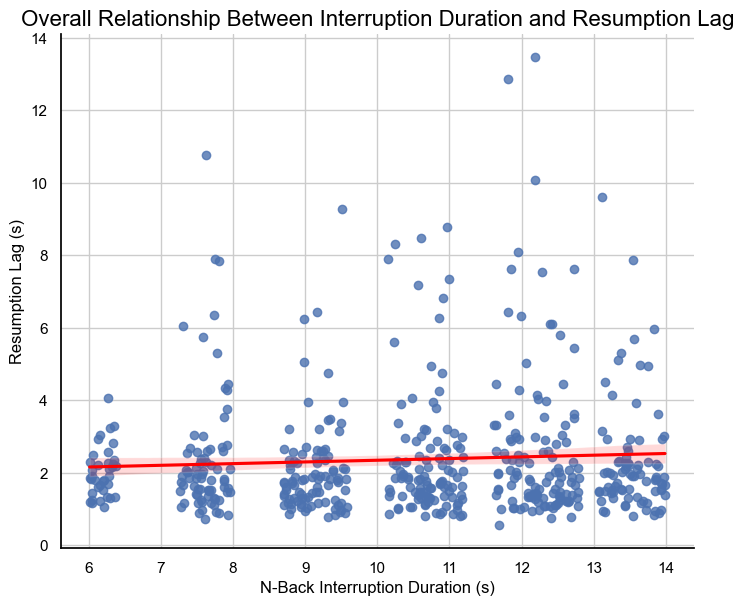

In [149]:
# Repeated-measures correlation: Duration vs Resumption Lag
rm_corr_rl = pg.rm_corr(data=df_lmm, x='nback_duration_s', y='OUT_resumption_lag', subject='participant_id')
display(rm_corr_rl)

sns.lmplot(
    data=df_lmm,
    x='nback_duration_s',
    y='OUT_resumption_lag',
    height=6,
    aspect=1.2,
    line_kws={'color': 'red'}
)

plt.title('Overall Relationship Between Interruption Duration and Resumption Lag', fontsize=16)
plt.xlabel('N-Back Interruption Duration (s)', fontsize=12)
plt.ylabel('Resumption Lag (s)', fontsize=12)
plt.show()

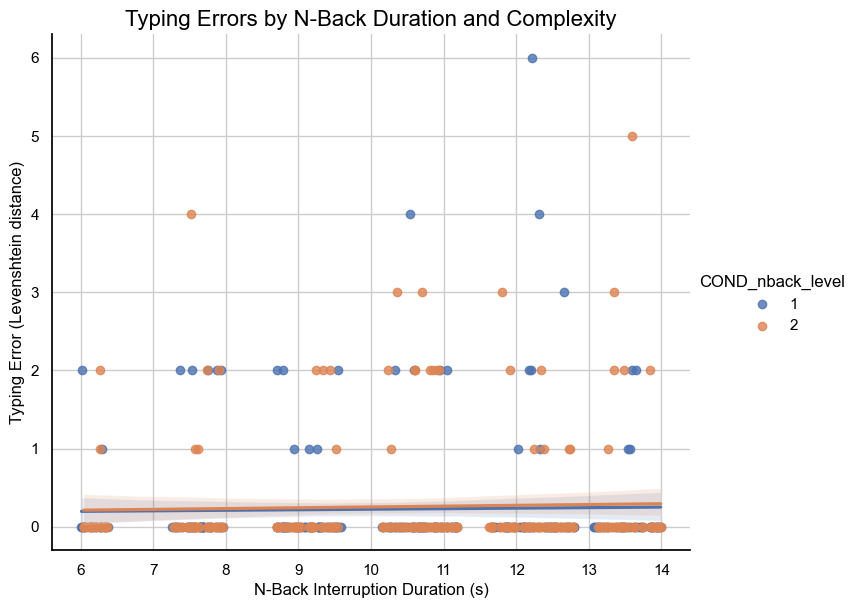

In [150]:
g = sns.lmplot(
    data=df_dur,
    x='nback_duration_s',
    y='OUT_typing_distance',
    hue='COND_nback_level',
    height=6,
    aspect=1.2
)

plt.title('Typing Errors by N-Back Duration and Complexity', fontsize=16)
plt.xlabel('N-Back Interruption Duration (s)', fontsize=12)
plt.ylabel('Typing Error (Levenshtein distance)', fontsize=12)
plt.show()

## N-back Accuracy

In [151]:
# Aggregate by participant x nback_level
nback_agg = (
    df_clean.groupby(["participant_id", "COND_nback_level"])["OUT_nback_accuracy"]
    .mean()
    .reset_index()
)
nback_wide = nback_agg.pivot(index="participant_id", columns="COND_nback_level", values="OUT_nback_accuracy")
nback_wide.columns = ["acc_1back", "acc_2back"]
nback_wide = nback_wide.dropna().reset_index()

nback_wide["diff"] = nback_wide["acc_1back"] - nback_wide["acc_2back"]

print(f"1-back accuracy: M = {nback_wide['acc_1back'].mean():.3f}, SD = {nback_wide['acc_1back'].std():.3f}")
print(f"2-back accuracy: M = {nback_wide['acc_2back'].mean():.3f}, SD = {nback_wide['acc_2back'].std():.3f}")

# Shapiro-Wilk on difference scores
w_stat, p_val = shapiro(nback_wide["diff"])
print(f"\nShapiro-Wilk on differences: W = {w_stat:.3f}, p = {p_val:.4f}")

# Wilcoxon (primary — normality likely violated)
wx_stat, wx_p = wilcoxon(nback_wide["acc_1back"], nback_wide["acc_2back"], alternative="greater")
print(f"\nWilcoxon (one-tailed, 1-back > 2-back): W = {wx_stat}, p = {wx_p:.4g}")

# Paired t-test (confirmatory)
t_result = pg.ttest(nback_wide["acc_1back"], nback_wide["acc_2back"], paired=True, alternative="greater")
print(f"Paired t-test: t({t_result['dof'].values[0]}) = {t_result['T'].values[0]:.2f}, "
      f"p = {t_result['p_val'].values[0]:.4g}, d = {t_result['cohen_d'].values[0]:.2f}")

1-back accuracy: M = 0.995, SD = 0.010
2-back accuracy: M = 0.983, SD = 0.012

Shapiro-Wilk on differences: W = 0.903, p = 0.0183

Wilcoxon (one-tailed, 1-back > 2-back): W = 286.0, p = 5.097e-05
Paired t-test: t(25) = 5.39, p = 6.797e-06, d = 1.02


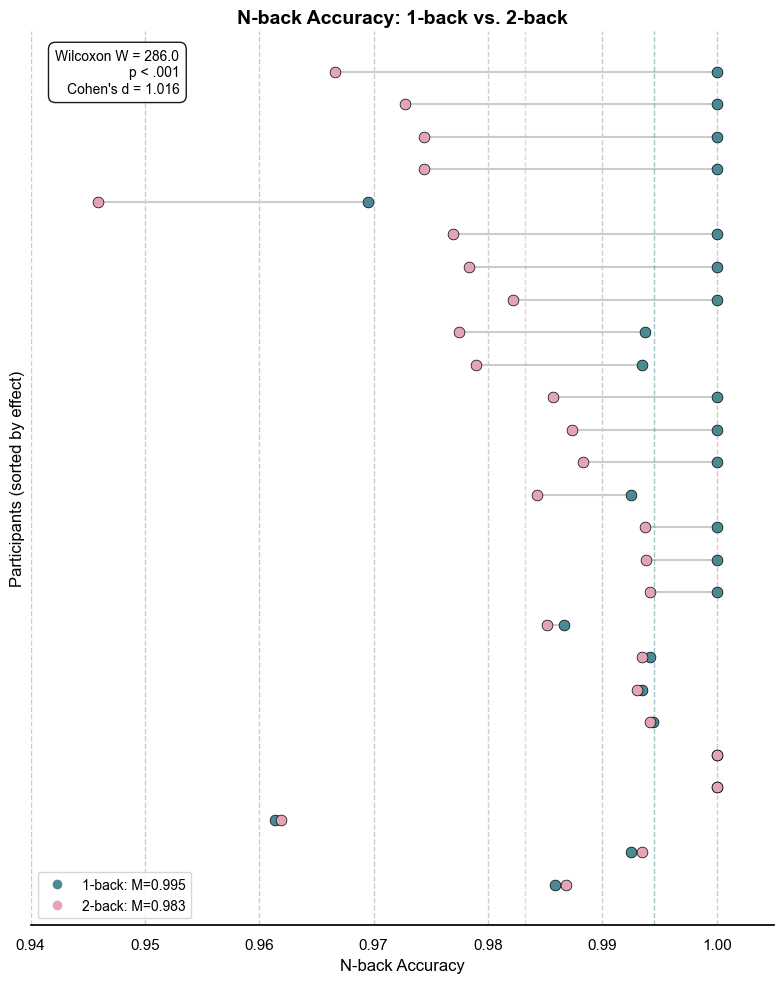

In [152]:
fig, ax = plt.subplots(figsize=(8, 10))

nback_wide_sorted = nback_wide.sort_values('diff', ascending=True).reset_index()

y_pos = np.arange(len(nback_wide_sorted))

for i, row in nback_wide_sorted.iterrows():
    ax.plot([row['acc_1back'], row['acc_2back']], [i, i],
            color='#CCCCCC', linewidth=1.5, zorder=1)
    ax.scatter(row['acc_1back'], i, color=COLORS['teal'], s=60,
               zorder=2, edgecolor=COLORS['primary_dark'], linewidth=0.5)
    ax.scatter(row['acc_2back'], i, color=COLORS['pink'], s=60,
               zorder=2, edgecolor=COLORS['primary_dark'], linewidth=0.5)

mean_1back = nback_wide['acc_1back'].mean()
mean_2back = nback_wide['acc_2back'].mean()

ax.axvline(mean_1back, color=COLORS['teal'], linestyle='--', alpha=0.5, linewidth=1)
ax.axvline(mean_2back, color=COLORS['pink'], linestyle='--', alpha=0.5, linewidth=1)

ax.set_xlabel('N-back Accuracy', fontsize=12, color=COLORS['primary_dark'])
ax.set_ylabel('Participants (sorted by effect)', fontsize=12, color=COLORS['primary_dark'])
ax.set_title('N-back Accuracy: 1-back vs. 2-back',
             fontsize=14, fontweight='bold', color=COLORS['primary_dark'])
ax.set_xlim(0.94, 1.005)
ax.set_yticks([])

ax.xaxis.grid(True, alpha=0.2, linestyle='--', color=COLORS['primary_dark'])
ax.set_axisbelow(True)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=COLORS['teal'],
           markersize=8, label=f'1-back: M={mean_1back:.3f}'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=COLORS['pink'],
           markersize=8, label=f'2-back: M={mean_2back:.3f}')
]
ax.legend(handles=legend_elements, loc='lower left', frameon=True, fontsize=10)

# Compute effect size
pooled_sd = np.sqrt((nback_wide['acc_1back'].std()**2 + nback_wide['acc_2back'].std()**2) / 2)
effect_size_d = (mean_1back - mean_2back) / pooled_sd if pooled_sd > 0 else 0

effect_text = (f'Wilcoxon W = 286.0\n'
               f'p < .001\n'
               f"Cohen\'s d = {effect_size_d:.3f}")
ax.text(0.2, 0.98, effect_text,
        transform=ax.transAxes,
        ha='right', va='top', fontsize=10,
        bbox=dict(boxstyle='round,pad=0.5',
                  facecolor=COLORS['white'],
                  edgecolor=COLORS['primary_dark'],
                  alpha=0.9))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

## Timing Properties

### Scalar Property

In [153]:
# Aggregate: per-participant variance and CV of time estimates by condition
timing_props = df_clean.groupby(GROUP_COLS, as_index=False).agg(
    mean_duration=("OUT_actual_trial_duration_sec", "mean"),
    var_estimate=("OUT_time_estimate_seconds", "var"),
    cv_estimate=("OUT_time_estimate_seconds", coefficient_of_variation),
    mean_estimate=("OUT_time_estimate_seconds", "mean"),
)

# Log-transform to address heteroscedasticity
timing_props["log_var"] = np.log(timing_props["var_estimate"].clip(lower=1e-10))
timing_props["log_cv"] = np.log(timing_props["cv_estimate"].clip(lower=1e-10))

# LMM 1: log(variance) ~ mean_duration
print("=== LMM: log(Variance) ~ Mean Duration ===")
md_var = smf.mixedlm("log_var ~ mean_duration",
                      data=timing_props, groups=timing_props["participant_id"]).fit()
print(md_var.summary().tables[1])

# LMM 2: log(CV) ~ mean_duration
print("\n=== LMM: log(CV) ~ Mean Duration ===")
md_cv = smf.mixedlm("log_cv ~ mean_duration",
                     data=timing_props, groups=timing_props["participant_id"]).fit()
print(md_cv.summary().tables[1])

=== LMM: log(Variance) ~ Mean Duration ===
               Coef. Std.Err.      z  P>|z|  [0.025 0.975]
Intercept      0.365    0.998  0.366  0.715  -1.591  2.321
mean_duration  0.062    0.045  1.393  0.163  -0.025  0.150
Group Var      0.284    0.198                             

=== LMM: log(CV) ~ Mean Duration ===
                Coef. Std.Err.       z  P>|z|  [0.025  0.975]
Intercept      -2.153    0.496  -4.338  0.000  -3.126  -1.180
mean_duration  -0.002    0.022  -0.097  0.923  -0.046   0.042
Group Var       0.080    0.107                               


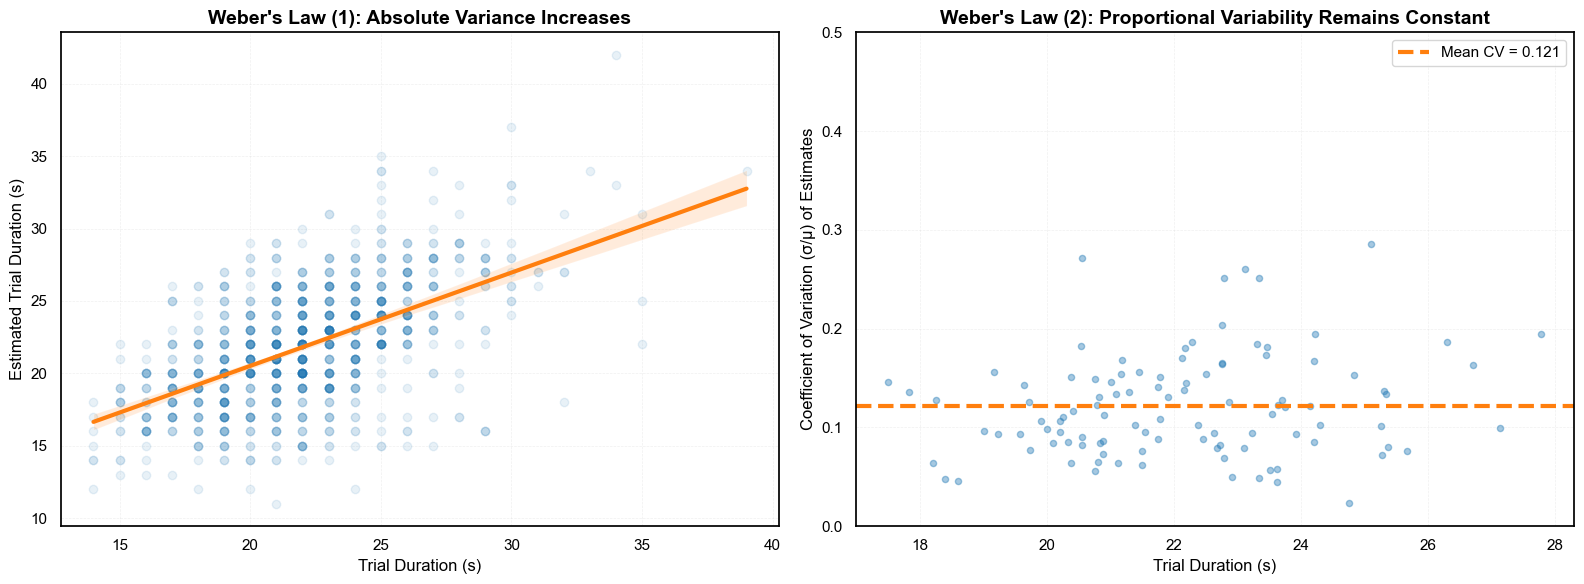

In [154]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# LEFT: Absolute variance increases
sns.regplot(data=df_clean, x='OUT_actual_trial_duration_sec', y='OUT_time_estimate_seconds',
            scatter_kws={'alpha': 0.1, 'color': '#1f77b4'},
            line_kws={'color': '#ff7f0e', 'linewidth': 3}, ax=ax1)
ax1.set_title("Weber's Law (1): Absolute Variance Increases", fontsize=14, fontweight='bold')
ax1.set_xlabel('Trial Duration (s)', fontsize=12)
ax1.set_ylabel('Estimated Trial Duration (s)', fontsize=12)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)

# RIGHT: CV remains constant
ax2.scatter(timing_props['mean_duration'], timing_props['cv_estimate'],
            alpha=0.4, color='#1f77b4', s=20)
ax2.axhline(y=timing_props['cv_estimate'].mean(), color='#ff7f0e',
            linestyle='--', linewidth=3,
            label=f'Mean CV = {timing_props["cv_estimate"].mean():.3f}')
ax2.set_title("Weber's Law (2): Proportional Variability Remains Constant", fontsize=14, fontweight='bold')
ax2.set_xlabel('Trial Duration (s)', fontsize=12)
ax2.set_ylabel('Coefficient of Variation (σ/μ) of Estimates', fontsize=12)
ax2.legend(loc='upper right', frameon=True)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)
ax2.set_ylim(0, 0.5)

plt.tight_layout()
plt.show()

### Central Tendency Effect

In [155]:
# Signed estimation error (subjective - objective)
df_clean["estimation_error"] = (
    df_clean["OUT_time_estimate_seconds"] - df_clean["OUT_actual_trial_duration_sec"]
)
df_clean["log_SO_ratio"] = np.log(df_clean["OUT_time_estimation_ratio"].clip(lower=1e-10))

# LMM: estimation_error ~ trial_duration
print("=== LMM: Estimation Error ~ Trial Duration ===")
md_vierordt = smf.mixedlm(
    "estimation_error ~ OUT_actual_trial_duration_sec",
    data=df_clean, groups=df_clean["participant_id"]
).fit()
print(md_vierordt.summary().tables[1])

# Indifference point
intercept = md_vierordt.fe_params["Intercept"]
slope = md_vierordt.fe_params["OUT_actual_trial_duration_sec"]
indifference = -intercept / slope
print(f"\nIndifference point: {indifference:.2f} s")

# Log-transformed model
print("\n=== LMM: log(SO_ratio) ~ Trial Duration ===")
md_log = smf.mixedlm(
    "log_SO_ratio ~ OUT_actual_trial_duration_sec",
    data=df_clean, groups=df_clean["participant_id"]
).fit()
print(md_log.summary().tables[1])

intercept_log = md_log.fe_params["Intercept"]
slope_log = md_log.fe_params["OUT_actual_trial_duration_sec"]
indifference_log = -intercept_log / slope_log
print(f"Indifference point (log model): {indifference_log:.2f} s")

=== LMM: Estimation Error ~ Trial Duration ===
                                Coef. Std.Err.        z  P>|z|  [0.025  0.975]
Intercept                       8.414    0.734   11.459  0.000   6.975   9.853
OUT_actual_trial_duration_sec  -0.393    0.025  -15.784  0.000  -0.441  -0.344
Group Var                       6.026    0.717                                

Indifference point: 21.43 s

=== LMM: log(SO_ratio) ~ Trial Duration ===
                                Coef. Std.Err.        z  P>|z|  [0.025  0.975]
Intercept                       0.367    0.035   10.610  0.000   0.299   0.434
OUT_actual_trial_duration_sec  -0.017    0.001  -14.988  0.000  -0.020  -0.015
Group Var                       0.014    0.035                                
Indifference point (log model): 21.12 s


                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     err_sec   
No. Observations:      958         Method:                 REML      
No. Groups:            26          Scale:                  5.6453    
Min. group size:       31          Log-Likelihood:         -2253.8970
Max. group size:       40          Converged:              Yes       
Mean group size:       36.8                                          
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.289    0.478 -0.604 0.546 -1.227  0.649
dur_c                      -0.415    0.049 -8.456 0.000 -0.511 -0.319
participant_id Var          5.771    0.718                           
participant_id x dur_c Cov  0.171    0.053                           
dur_c Var                   0.047   

/Users/manosfrg/Documents/MyCode/dunderscore_ai/portfolio-projects/msc-thesis-cleanup/computational-modeling-time-perception/.venv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


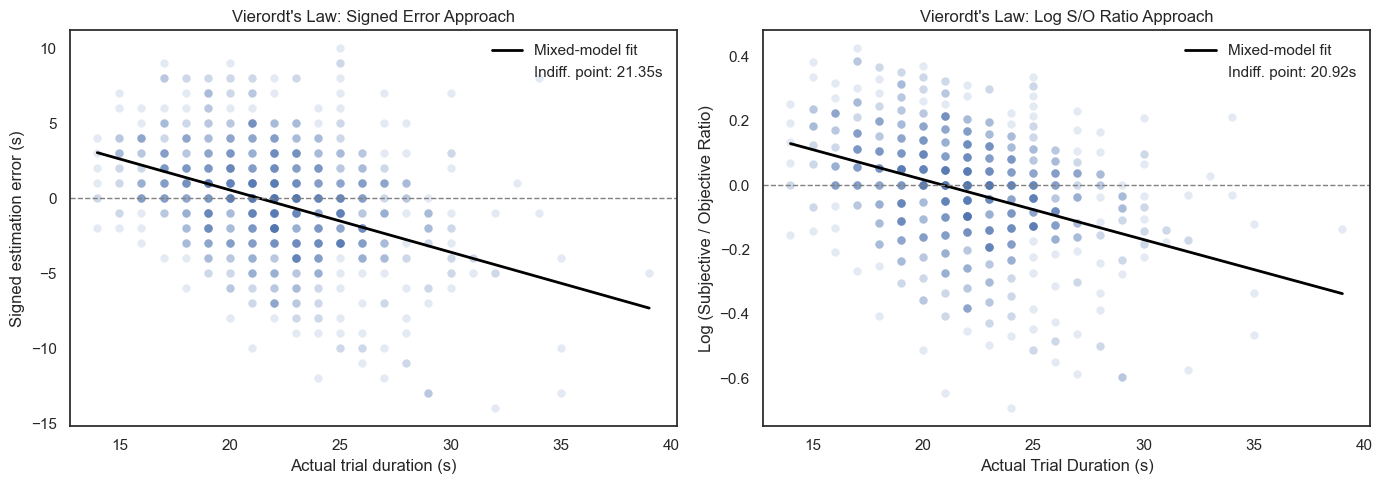

In [156]:
df_v = df_clean.copy()
df_v["err_sec"] = df_v["OUT_time_estimate_seconds"] - df_v["OUT_actual_trial_duration_sec"]
grand_mean_dur = df_v["OUT_actual_trial_duration_sec"].mean()
df_v["dur_c"] = df_v["OUT_actual_trial_duration_sec"] - grand_mean_dur

df_v["so_ratio"] = df_v["OUT_time_estimate_seconds"] / (df_v["OUT_actual_trial_duration_sec"] + 1e-9)
df_v["log_so_ratio"] = np.log(df_v["so_ratio"] + 1e-9)

model1 = smf.mixedlm("err_sec ~ dur_c", df_v, groups="participant_id",
                      re_formula="~dur_c").fit(method="lbfgs")
print(model1.summary())

model2 = smf.mixedlm("log_so_ratio ~ dur_c", df_v, groups="participant_id",
                      re_formula="~dur_c").fit(method="lbfgs")
print(model2.summary())

b0_1, b1_1 = model1.params["Intercept"], model1.params["dur_c"]
indiff_1 = -b0_1 / b1_1 + grand_mean_dur
print(f"\nModel 1 Indifference point: {indiff_1:.2f} s")

b0_2, b1_2 = model2.params["Intercept"], model2.params["dur_c"]
indiff_2 = -b0_2 / b1_2 + grand_mean_dur
print(f"Model 2 Indifference point: {indiff_2:.2f} s")

sns.set(style="white", context="notebook")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
sns.scatterplot(data=df_v, x="OUT_actual_trial_duration_sec", y="err_sec",
                alpha=.15, linewidth=0, edgecolor=None, ax=ax1)
x1 = np.linspace(df_v["OUT_actual_trial_duration_sec"].min(),
                 df_v["OUT_actual_trial_duration_sec"].max(), 200)
y1 = b0_1 + b1_1 * (x1 - grand_mean_dur)
ax1.plot(x1, y1, color="black", lw=2, label="Mixed-model fit")
ax1.axhline(0, ls="--", c="grey", lw=1)
ax1.plot([], [], ' ', label=f"Indiff. point: {indiff_1:.2f}s")
ax1.set_xlabel("Actual trial duration (s)")
ax1.set_ylabel("Signed estimation error (s)")
ax1.set_title("Vierordt's Law: Signed Error Approach")
ax1.legend(frameon=False, loc='upper right')

ax2 = axes[1]
sns.scatterplot(data=df_v, x="OUT_actual_trial_duration_sec", y="log_so_ratio",
                alpha=.15, linewidth=0, edgecolor=None, ax=ax2)
x2 = np.linspace(df_v["OUT_actual_trial_duration_sec"].min(),
                 df_v["OUT_actual_trial_duration_sec"].max(), 200)
y2 = b0_2 + b1_2 * (x2 - grand_mean_dur)
ax2.plot(x2, y2, color="black", lw=2, label="Mixed-model fit")
ax2.axhline(0, ls="--", c="grey", lw=1)
ax2.plot([], [], ' ', label=f"Indiff. point: {indiff_2:.2f}s")
ax2.set_xlabel("Actual Trial Duration (s)")
ax2.set_ylabel("Log (Subjective / Objective Ratio)")
ax2.set_title("Vierordt's Law: Log S/O Ratio Approach")
ax2.legend(frameon=False, loc='upper right')

plt.tight_layout()
plt.show()

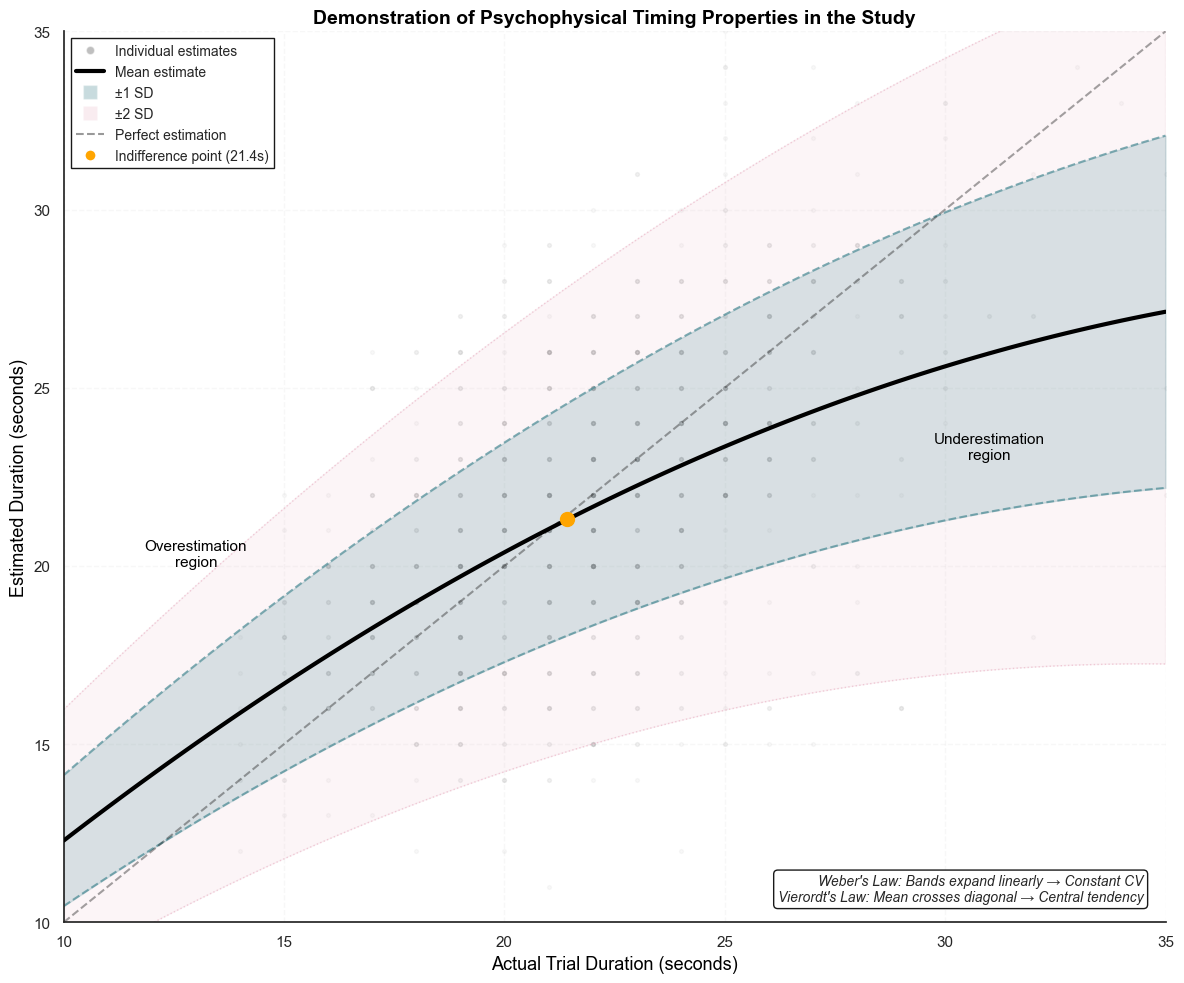

In [157]:
fig, ax = plt.subplots(figsize=(12, 10))

x = df_clean['OUT_actual_trial_duration_sec'].values
y = df_clean['OUT_time_estimate_seconds'].values

ax.scatter(x, y, alpha=0.05, s=8, color='gray', zorder=1)

n_bins = 20
bin_edges = np.percentile(x, np.linspace(0, 100, n_bins + 1))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

means = []
sds = []
for i in range(n_bins):
    mask = (x >= bin_edges[i]) & (x < bin_edges[i + 1])
    if mask.sum() > 2:
        means.append(y[mask].mean())
        sds.append(y[mask].std())
    else:
        means.append(np.nan)
        sds.append(np.nan)

valid = ~np.isnan(means)
bin_centers = bin_centers[valid]
means = np.array(means)[valid]
sds = np.array(sds)[valid]

z = np.polyfit(bin_centers, means, 2)
p_mean = np.poly1d(z)
z_sd = np.polyfit(bin_centers, sds, 1)
p_sd = np.poly1d(z_sd)

x_smooth = np.linspace(10, 35, 100)
y_mean = p_mean(x_smooth)
y_sd = p_sd(x_smooth)

ax.plot(x_smooth, y_mean, color=COLORS['primary_dark'], linewidth=3, zorder=3)

ax.fill_between(x_smooth, y_mean - y_sd, y_mean + y_sd,
                color=COLORS['teal'], alpha=0.2, zorder=2)
ax.plot(x_smooth, y_mean + y_sd, color=COLORS['teal'], linewidth=1.5,
        linestyle='--', alpha=0.7, zorder=2)
ax.plot(x_smooth, y_mean - y_sd, color=COLORS['teal'], linewidth=1.5,
        linestyle='--', alpha=0.7, zorder=2)

ax.fill_between(x_smooth, y_mean - 2*y_sd, y_mean + 2*y_sd,
                color=COLORS['pink'], alpha=0.1, zorder=1)
ax.plot(x_smooth, y_mean + 2*y_sd, color=COLORS['pink'], linewidth=1,
        linestyle=':', alpha=0.5, zorder=2)
ax.plot(x_smooth, y_mean - 2*y_sd, color=COLORS['pink'], linewidth=1,
        linestyle=':', alpha=0.5, zorder=2)

ax.plot([10, 35], [10, 35], 'k--', alpha=0.4, linewidth=1.5, zorder=2)

indiff_x = indifference
indiff_y = p_mean(indiff_x)
ax.scatter([indiff_x], [indiff_y], color='orange', s=100, marker='o', zorder=5, linewidth=1)

ax.annotate('Overestimation\nregion', xy=(16, 17), xytext=(13, 20),
            fontsize=11, ha='center', color=COLORS['primary_dark'])
ax.annotate('Underestimation\nregion', xy=(27, 26), xytext=(31, 23),
            fontsize=11, ha='center', color=COLORS['primary_dark'])

ax.set_xlabel('Actual Trial Duration (seconds)', fontsize=13, color=COLORS['primary_dark'])
ax.set_ylabel('Estimated Duration (seconds)', fontsize=13, color=COLORS['primary_dark'])
ax.set_title('Demonstration of Psychophysical Timing Properties in the Study',
             fontsize=14, fontweight='bold', color=COLORS['primary_dark'])
ax.set_xlim(10, 35)
ax.set_ylim(10, 35)

ax.grid(True, alpha=0.15, linestyle='--')
ax.set_axisbelow(True)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
           markersize=6, alpha=0.5, label='Individual estimates', linestyle='None'),
    Line2D([0], [0], color=COLORS['primary_dark'], linewidth=3,
           label='Mean estimate'),
    Line2D([0], [0], color='w', markerfacecolor=COLORS['teal'], alpha=0.3,
           marker='s', markersize=10, label='\u00b11 SD', linestyle='None'),
    Line2D([0], [0], color='w', markerfacecolor=COLORS['pink'], alpha=0.2,
           marker='s', markersize=10, label='\u00b12 SD', linestyle='None'),
    Line2D([0], [0], color='black', linewidth=1.5, linestyle='--',
           alpha=0.4, label='Perfect estimation'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange',
           markersize=8, label=f'Indifference point ({indiff_x:.1f}s)', linestyle='None')
]

legend = ax.legend(handles=legend_elements, loc='upper left', frameon=True,
                   fontsize=10, fancybox=False, edgecolor=COLORS['primary_dark'])
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.9)

interpretation = ("Weber\'s Law: Bands expand linearly \u2192 Constant CV\n"
                  "Vierordt\'s Law: Mean crosses diagonal \u2192 Central tendency")
ax.text(0.98, 0.02, interpretation, transform=ax.transAxes, fontsize=10,
        ha='right', va='bottom', style='italic',
        bbox=dict(boxstyle='round', facecolor='white',
                  edgecolor=COLORS['primary_dark'], alpha=0.9))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

## Time Perception: 2\u00d72 Repeated-Measures ANOVAs

### Assumption Checking

In [158]:
# Aggregate time perception at participant x condition level
agg_tp = df_clean.groupby(GROUP_COLS, as_index=False).agg(
    mean_abs_error=("OUT_normalized_absolute_error", "mean"),
    mean_SO_ratio=("OUT_time_estimation_ratio", "mean"),
    cv_estimate=("OUT_time_estimate_seconds", coefficient_of_variation),
)

tp_dvs = ["mean_abs_error", "mean_SO_ratio", "cv_estimate"]

# Cell-level outlier screening (per-cell z > 3.29)
for dv in tp_dvs:
    agg_tp["_outlier_uni"] = False
    for _, grp in agg_tp.groupby(["COND_interruption_condition", "COND_nback_level"]):
        z = zscore(grp[dv], nan_policy="omit")
        mask = np.abs(z) > 3.29
        agg_tp.loc[grp.index, "_outlier_uni"] = mask
    n_uni = agg_tp["_outlier_uni"].sum()
    if n_uni > 0:
        for idx in agg_tp.index[agg_tp["_outlier_uni"]]:
            row = agg_tp.loc[idx]
            cell_mask = (
                (agg_tp["COND_interruption_condition"] == row["COND_interruption_condition"])
                & (agg_tp["COND_nback_level"] == row["COND_nback_level"])
                & (agg_tp.index != idx)
            )
            agg_tp.loc[idx, dv] = agg_tp.loc[cell_mask, dv].median()
        print(f"{dv}: {n_uni} univariate outlier(s) winsorised (per-cell z > 3.29).")
    else:
        print(f"{dv}: no univariate outliers.")
    agg_tp.drop(columns=["_outlier_uni"], inplace=True)

# Multivariate: Mahalanobis on 4-cell vectors per participant per DV
for dv in tp_dvs:
    wide = (
        agg_tp.pivot(index="participant_id",
                     columns=["COND_interruption_condition", "COND_nback_level"],
                     values=dv)
        .dropna()
    )
    X = wide.values
    mean = X.mean(axis=0)
    cov = np.cov(X.T)
    if np.linalg.det(cov) == 0:
        print(f"{dv}: covariance matrix is singular; skipping multivariate check.")
        continue
    cov_inv = np.linalg.inv(cov)
    diff = X - mean
    md = np.sqrt(np.sum(diff @ cov_inv * diff, axis=1))
    cutoff = np.sqrt(chi2.ppf(1 - 0.001, df=wide.shape[1]))
    multi_flags = md > cutoff
    n_multi = multi_flags.sum()
    if n_multi > 0:
        outlier_pids = wide.index[multi_flags]
        for pid in outlier_pids:
            pid_mask = agg_tp["participant_id"] == pid
            cell_median = agg_tp.loc[~pid_mask, dv].median()
            agg_tp.loc[pid_mask, dv] = cell_median
        print(f"{dv}: {n_multi} multivariate outlier(s) winsorised.")
    else:
        print(f"{dv}: no multivariate outliers.")

mean_abs_error: no univariate outliers.
mean_SO_ratio: no univariate outliers.
cv_estimate: no univariate outliers.
mean_abs_error: no multivariate outliers.
mean_SO_ratio: no multivariate outliers.
cv_estimate: no multivariate outliers.



Shapiro-Wilk on residuals of mean_abs_error: W = 0.886, p = 0.0000
  -> Residuals significantly deviate from normality (p < 0.05).


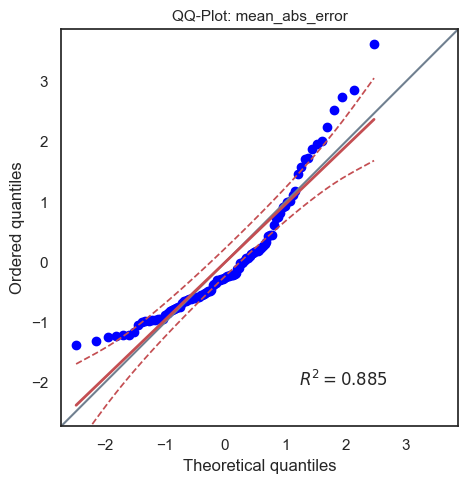


Shapiro-Wilk on residuals of mean_SO_ratio: W = 0.968, p = 0.0140
  -> Residuals significantly deviate from normality (p < 0.05).


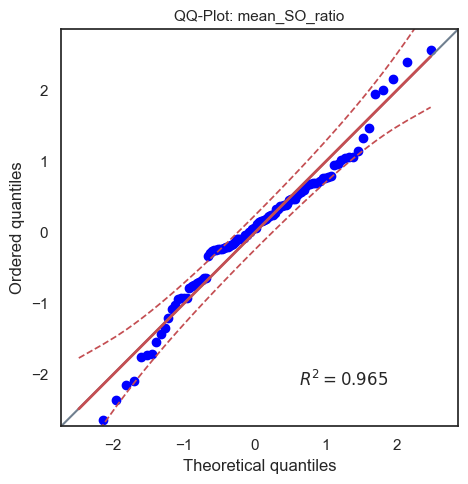


Shapiro-Wilk on residuals of cv_estimate: W = 0.947, p = 0.0004
  -> Residuals significantly deviate from normality (p < 0.05).


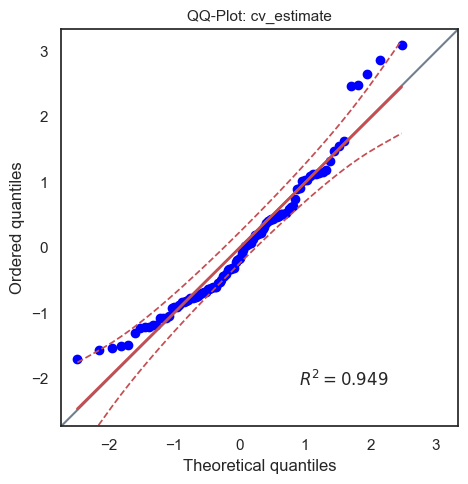

In [159]:
# Normality checks
for dv in tp_dvs:
    normality_check(agg_tp, dv, WITHIN, SUBJECT)

In [160]:
# Variance equality
# Create condition label for grouping
if "condition_label" not in agg_tp.columns:
    agg_tp["condition_label"] = agg_tp.apply(create_condition_label, axis=1)

for dv in tp_dvs:
    variance_equality_tests(agg_tp, dv, "condition_label")


Variance equality for mean_abs_error:
  Brown-Forsythe: F = 0.01, p = 0.999
  Fligner-Killeen: chi2 = 0.67, p = 0.880

Variance equality for mean_SO_ratio:
  Brown-Forsythe: F = 0.29, p = 0.834
  Fligner-Killeen: chi2 = 1.35, p = 0.716

Variance equality for cv_estimate:
  Brown-Forsythe: F = 0.33, p = 0.802
  Fligner-Killeen: chi2 = 1.20, p = 0.752


### Results

In [161]:
report_rm_anova(agg_tp, "mean_abs_error")


=== Repeated-measures ANOVA on mean_abs_error ===
                                        Effect     SS  df1  df2     MS     F      p   ng2 sig
                   COND_interruption_condition 0.0065    1   25 0.0065 3.624 0.0685 0.013    
                              COND_nback_level 0.0011    1   25 0.0011 0.615 0.4405 0.002    
COND_interruption_condition * COND_nback_level 0.0003    1   25 0.0003 0.262 0.6130 0.001    

Post-hoc paired t-tests (Holm-corrected, α = .05)
  – none survive correction.


,Source,SS,ddof1,ddof2,MS,F,p_unc,p_GG_corr,ng2,eps
0,COND_interruption_condition,0.006509,1,25,0.006509,3.624259,0.068515,0.068515,0.012851,1.0
1,COND_nback_level,0.001124,1,25,0.001124,0.614501,0.440463,0.440463,0.002244,1.0
2,COND_interruption_condition * COND_nback_level,0.000334,1,25,0.000334,0.262419,0.612959,0.612959,0.000667,1.0


In [162]:
report_rm_anova(agg_tp, "mean_SO_ratio")


=== Repeated-measures ANOVA on mean_SO_ratio ===
                                        Effect     SS  df1  df2     MS     F      p   ng2 sig
                   COND_interruption_condition 0.0008    1   25 0.0008 0.171 0.6827 0.000    
                              COND_nback_level 0.0084    1   25 0.0084 2.381 0.1354 0.005    
COND_interruption_condition * COND_nback_level 0.0000    1   25 0.0000 0.008 0.9306 0.000    

Post-hoc paired t-tests (Holm-corrected, α = .05)
  – none survive correction.


,Source,SS,ddof1,ddof2,MS,F,p_unc,p_GG_corr,ng2,eps
0,COND_interruption_condition,0.000774,1,25,0.000774,0.171011,0.682741,0.682741,0.000491,1.0
1,COND_nback_level,0.008411,1,25,0.008411,2.381330,0.135358,0.135358,0.005313,1.0
2,COND_interruption_condition * COND_nback_level,0.000023,1,25,0.000023,0.007740,0.930595,0.930595,0.000015,1.0


In [163]:
report_rm_anova(agg_tp, "cv_estimate")


=== Repeated-measures ANOVA on cv_estimate ===
                                        Effect     SS  df1  df2     MS     F      p   ng2 sig
                   COND_interruption_condition 0.0007    1   25 0.0007 0.398 0.5339 0.003    
                              COND_nback_level 0.0017    1   25 0.0017 1.247 0.2748 0.006    
COND_interruption_condition * COND_nback_level 0.0016    1   25 0.0016 1.244 0.2754 0.006    

Post-hoc paired t-tests (Holm-corrected, α = .05)
  – none survive correction.


,Source,SS,ddof1,ddof2,MS,F,p_unc,p_GG_corr,ng2,eps
0,COND_interruption_condition,0.000704,1,25,0.000704,0.397853,0.533924,0.533924,0.002573,1.0
1,COND_nback_level,0.001717,1,25,0.001717,1.246910,0.274761,0.274761,0.006251,1.0
2,COND_interruption_condition * COND_nback_level,0.001593,1,25,0.001593,1.243592,0.275385,0.275385,0.005800,1.0


In [164]:
# ART ANOVA for CV (normality violated)
art_anova(agg_tp, "cv_estimate", WITHIN, SUBJECT)


=== ART ANOVA on cv_estimate ===
                                        Effect    F  df1  df2      p sig
                   COND_interruption_condition 0.10    1   25 0.7517    
                              COND_nback_level 1.19    1   25 0.2858    
COND_interruption_condition x COND_nback_level 1.13    1   25 0.2983    


,Effect,F,df1,df2,p,sig
0,COND_interruption_condition,0.10,1,25,0.7517,
1,COND_nback_level,1.19,1,25,0.2858,
2,COND_interruption_condition x COND_nback_level,1.13,1,25,0.2983,


### Visualizations

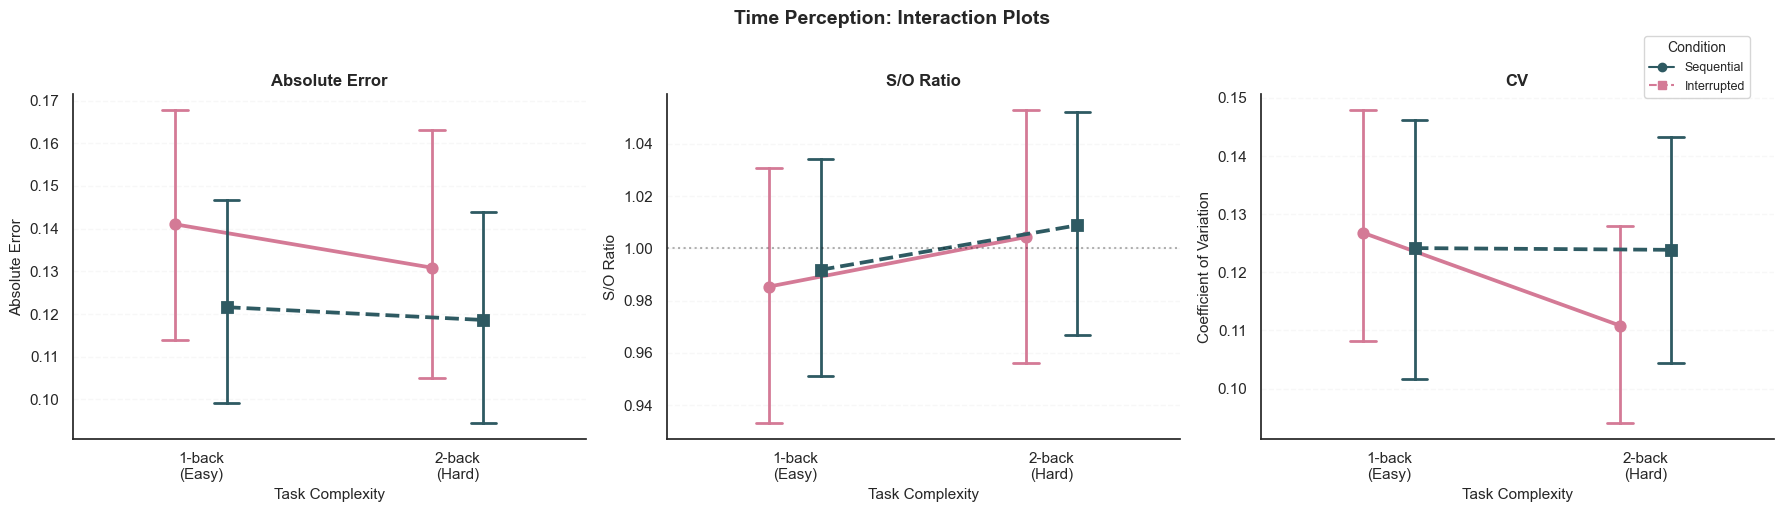

In [165]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, dv, ylabel, title in [
    (axes[0], "mean_abs_error", "Absolute Error", "Absolute Error"),
    (axes[1], "mean_SO_ratio", "S/O Ratio", "S/O Ratio"),
    (axes[2], "cv_estimate", "Coefficient of Variation", "CV"),
]:
    sns.pointplot(
        data=agg_tp, x="COND_nback_level", y=dv,
        hue="COND_interruption_condition",
        dodge=0.2, markers=["o", "s"], linestyles=["-", "--"],
        palette={"sequential": COLORS["teal_dark"], "interrupted": COLORS["pink_dark"]},
        capsize=0.1, err_kws={"linewidth": 2}, ax=ax, legend=False,
    )
    ax.set_xlabel("Task Complexity", fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["1-back\n(Easy)", "2-back\n(Hard)"])
    ax.yaxis.grid(True, alpha=0.15, linestyle="--")
    ax.set_axisbelow(True)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if dv == "mean_SO_ratio":
        ax.axhline(y=1.0, color=COLORS["primary_dark"], linestyle=":", alpha=0.3)

legend_elements = [
    Line2D([0], [0], color=COLORS["teal_dark"], linestyle="-", marker="o", markersize=6, label="Sequential"),
    Line2D([0], [0], color=COLORS["pink_dark"], linestyle="--", marker="s", markersize=6, label="Interrupted"),
]
fig.legend(handles=legend_elements, title="Condition", loc="upper right",
           bbox_to_anchor=(0.98, 0.98), frameon=True, fontsize=9, title_fontsize=10)
fig.suptitle("Time Perception: Interaction Plots", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

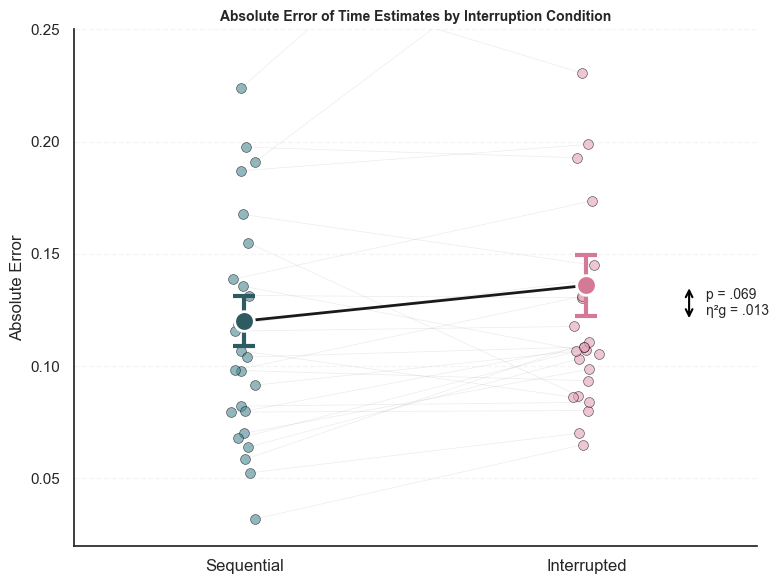

In [166]:
fig, ax = plt.subplots(figsize=(8, 6))

abs_wide = (agg_tp.groupby(['participant_id', 'COND_interruption_condition'])
            .agg({'mean_abs_error': 'mean'})
            .unstack('COND_interruption_condition')
            .droplevel(0, axis=1))

data_seq = abs_wide['sequential'].values
data_int = abs_wide['interrupted'].values

np.random.seed(42)
x_seq = np.ones(len(data_seq)) + np.random.normal(0, 0.02, len(data_seq))
x_int = 2 * np.ones(len(data_int)) + np.random.normal(0, 0.02, len(data_int))

ax.scatter(x_seq, data_seq, color=COLORS['teal'], alpha=0.6, s=50,
           edgecolor=COLORS['primary_dark'], linewidth=0.5)
ax.scatter(x_int, data_int, color=COLORS['pink'], alpha=0.6, s=50,
           edgecolor=COLORS['primary_dark'], linewidth=0.5)

for i in range(len(data_seq)):
    ax.plot([x_seq[i], x_int[i]], [data_seq[i], data_int[i]],
            color='gray', alpha=0.15, linewidth=0.5, zorder=0)

mean_seq = data_seq.mean()
mean_int = data_int.mean()
sem_seq = data_seq.std() / np.sqrt(len(data_seq))
sem_int = data_int.std() / np.sqrt(len(data_int))

ax.errorbar([1], [mean_seq], yerr=[sem_seq], color=COLORS['teal_dark'],
            linewidth=3, capsize=8, capthick=3, zorder=10)
ax.errorbar([2], [mean_int], yerr=[sem_int], color=COLORS['pink_dark'],
            linewidth=3, capsize=8, capthick=3, zorder=10)

ax.plot([1, 2], [mean_seq, mean_int], 'k-', linewidth=2, zorder=9)

ax.scatter([1], [mean_seq], color=COLORS['teal_dark'], s=200,
           edgecolor='white', linewidth=2, zorder=11)
ax.scatter([2], [mean_int], color=COLORS['pink_dark'], s=200,
           edgecolor='white', linewidth=2, zorder=11)

ax.set_xticks([1, 2])
ax.set_xticklabels(['Sequential', 'Interrupted'], fontsize=12)
ax.set_ylabel('Absolute Error', fontsize=12)
ax.set_title('Absolute Error of Time Estimates by Interruption Condition',
             fontsize=10, fontweight='bold')
ax.set_xlim(0.5, 2.5)
ax.set_ylim(0.02, 0.25)

diff = mean_int - mean_seq
ax.annotate('', xy=(2.3, mean_int), xytext=(2.3, mean_seq),
            arrowprops=dict(arrowstyle='<->', color=COLORS['primary_dark'], lw=1.5))
ax.text(2.35, (mean_seq + mean_int)/2, f'p = .069\nη²g = .013',
        fontsize=10, va='center')

ax.yaxis.grid(True, alpha=0.2, linestyle='--')
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

## Correlation: Performance and Time Perception Disruption

In [168]:
# Compute delta scores per participant
perf_by_int = (
    df_clean.groupby(["participant_id", "COND_interruption_condition"])
    .agg(
        mean_tpl=("OUT_time_per_letter", "mean"),
        mean_ae=("OUT_normalized_absolute_error", "mean"),
    )
    .reset_index()
)

delta_wide = perf_by_int.pivot(index="participant_id", columns="COND_interruption_condition",
                                values=["mean_tpl", "mean_ae"])
delta_wide.columns = ["_".join(c) for c in delta_wide.columns]
delta_wide = delta_wide.reset_index()

delta_wide["delta_tpl"] = delta_wide["mean_tpl_interrupted"] - delta_wide["mean_tpl_sequential"]
delta_wide["delta_ae"] = delta_wide["mean_ae_interrupted"] - delta_wide["mean_ae_sequential"]

print(f"N = {len(delta_wide)} participants")
print(f"Delta time_per_letter: M = {delta_wide['delta_tpl'].mean():.3f}, SD = {delta_wide['delta_tpl'].std():.3f}")
print(f"Delta absolute_error:  M = {delta_wide['delta_ae'].mean():.3f}, SD = {delta_wide['delta_ae'].std():.3f}")

N = 26 participants
Delta time_per_letter: M = 0.290, SD = 0.144
Delta absolute_error:  M = 0.015, SD = 0.044


### Assumption Checking

In [169]:
# Homoscedasticity: Breusch-Pagan
X = sm.add_constant(delta_wide["delta_tpl"])
model = sm.OLS(delta_wide["delta_ae"], X).fit()
bp_stat, bp_p, _, _ = het_breuschpagan(model.resid, X)
print(f"Breusch-Pagan: chi2(1) = {bp_stat:.2f}, p = {bp_p:.3f}")

# Normality
for col, label in [("delta_tpl", "delta_time_per_letter"), ("delta_ae", "delta_absolute_error")]:
    w, p = shapiro(delta_wide[col])
    print(f"Shapiro-Wilk ({label}): W = {w:.3f}, p = {p:.4f}")

# Bivariate normality: Henze-Zirkler
hz = pg.multivariate_normality(
    delta_wide[["delta_tpl", "delta_ae"]], alpha=ALPHA
)
print(f"\nHenze-Zirkler: HZ = {hz.hz:.2f}, p = {hz.pval:.4f}, normal = {hz.normal}")

# Outlier detection
# IQR-based
for col in ["delta_tpl", "delta_ae"]:
    flags = flag_outliers_iqr(delta_wide[col], k=2.5)
    print(f"IQR outliers ({col}): {flags.sum()}")

# Mahalanobis
md, md_p = mahalanobis_distances(delta_wide, ["delta_tpl", "delta_ae"])
multi_outliers = md_p < 0.01
print(f"Multivariate outliers (Mahalanobis, alpha=.01): {multi_outliers.sum()}")

Breusch-Pagan: chi2(1) = 0.33, p = 0.568
Shapiro-Wilk (delta_time_per_letter): W = 0.742, p = 0.0000
Shapiro-Wilk (delta_absolute_error): W = 0.898, p = 0.0145

Henze-Zirkler: HZ = 1.61, p = 0.0003, normal = False
IQR outliers (delta_tpl): 1
IQR outliers (delta_ae): 1
Multivariate outliers (Mahalanobis, alpha=.01): 2


### Results

In [170]:
# Pearson correlation (full sample)
r, p = stats.pearsonr(delta_wide["delta_tpl"], delta_wide["delta_ae"])
n = len(delta_wide)
print(f"Full sample (N = {n}):")
print(f"  Pearson r({n-2}) = {r:.2f}, p = {p:.3f}")

# Bayes Factor
bf = pg.bayesfactor_pearson(r, n)
print(f"  BF10 = {bf:.2f}")

# Without outliers
delta_clean = delta_wide[~multi_outliers].copy()
r2, p2 = stats.pearsonr(delta_clean["delta_tpl"], delta_clean["delta_ae"])
n2 = len(delta_clean)
bf2 = pg.bayesfactor_pearson(r2, n2)
print(f"\nWithout outliers (N = {n2}):")
print(f"  Pearson r({n2-2}) = {r2:.2f}, p = {p2:.3f}")
print(f"  BF10 = {bf2:.2f}")

Full sample (N = 26):
  Pearson r(24) = -0.06, p = 0.775
  BF10 = 0.25

Without outliers (N = 24):
  Pearson r(22) = -0.03, p = 0.888
  BF10 = 0.26
